In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Content of Table

# Import & transform data

## Import data

In [2]:
DATA_DIR = Path('data/single_request')
LATENCY_CSV = 'single_request_latency.csv'
SERVER_USAGE_CSV = 'single_request_server_usage.csv'
CLIENT_USAGE_CSV = 'single_request_client_usage.csv'

In [3]:
df_latency = pd.read_csv(DATA_DIR / LATENCY_CSV)
df_server_usage = pd.read_csv(DATA_DIR / SERVER_USAGE_CSV)
df_client_usage = pd.read_csv(DATA_DIR / CLIENT_USAGE_CSV)

## Transform data

### Rename variables

In [4]:
df_latency = df_latency.rename(columns={
    'mode': 'protocol',
    'downlink_latency_ns': 'response_latency_ns'
    }
    )

### Standardise timestamps

Offset timestamps to a common baseline, which is the server start time for each epoch

In [5]:
def offset_timestamp_to_base(df, ts_cols: str | list[str], base_col='perf_base_ns'):
    """
    Offsets ts_col by subtracting base_col so timestamps start at zero.
    """
    cols = [ts_cols] if isinstance(ts_cols, str) else ts_cols

    for col in cols:
        df[col] = df[col] - df[base_col]

offset_timestamp_to_base(df_latency, ['t0', 't_req', 't_res', 't_in', 't_out'])
offset_timestamp_to_base(df_server_usage, 'ts')
offset_timestamp_to_base(df_client_usage, 'ts')

### Calculate Duration

Caluclate duration for each specific phase

In [6]:
df_latency['client_setup_ns'] = df_latency['t_req'] - df_latency['t0']

df_latency['uplink_latency_ns'] = df_latency['t_in']  - df_latency['t_req']

df_latency['request_latency_ns'] = df_latency['client_setup_ns'] + df_latency['uplink_latency_ns']

df_latency['server_processing_ns'] = df_latency['t_out'] - df_latency['t_in']

df_latency['response_latency_ns'] = df_latency['t_res'] - df_latency['t_out']

Calculate end-to-end duration

In [7]:
df_latency['round_trip_ns'] = df_latency['t_res'] - df_latency['t_req']

df_latency['total_runtime_ns'] = df_latency['t_res'] - df_latency['t0']

Calculate % of each specific phase of total run time

In [8]:
df_latency['client_setup_perc'] = df_latency['client_setup_ns'] / df_latency['total_runtime_ns']

df_latency['uplink_latency_perc'] = df_latency['uplink_latency_ns'] / df_latency['total_runtime_ns']

df_latency['request_latency_perc'] = df_latency['request_latency_ns'] / df_latency['total_runtime_ns']

df_latency['server_processing_perc'] = df_latency['server_processing_ns'] / df_latency['total_runtime_ns']

df_latency['response_latency_perc'] = df_latency['response_latency_ns'] / df_latency['total_runtime_ns']

### Caulculate speed

In [9]:
df_latency['item_per_s_request'] = (df_latency['size'] / df_latency['request_latency_ns']) * 1_000_000_000
df_latency['items_per_s_server'] = (df_latency['size'] / df_latency['server_processing_ns']) * 1_000_000_000
df_latency['items_per_s_response'] = (df_latency['size'] / df_latency['response_latency_ns']) * 1_000_000_000

df_latency['items_per_s_total_runtime'] = (df_latency['size'] / df_latency['total_runtime_ns']) * 1_000_000_000

In [10]:
df_latency['kb_per_s_request'] = (df_latency['res_size_bytes'] / df_latency['request_latency_ns']) / 1024 * 1_000_000_000
df_latency['kb_per_s_server'] = (df_latency['res_size_bytes'] / df_latency['server_processing_ns']) / 1024 * 1_000_000_000
df_latency['kb_per_s_response'] = (df_latency['res_size_bytes'] / df_latency['response_latency_ns']) / 1024 * 1_000_000_000

df_latency['kb_per_s_total_runtime'] = (df_latency['res_size_bytes'] / df_latency['total_runtime_ns']) / 1024 * 1_000_000_000

In [11]:
df_latency

,protocol,size,req_id,t0,t_req,t_res,t_in,t_out,perf_base_ns,epoch_base_ns,...,server_processing_perc,response_latency_perc,item_per_s_request,items_per_s_server,items_per_s_response,items_per_s_total_runtime,kb_per_s_request,kb_per_s_server,kb_per_s_response,kb_per_s_total_runtime
0,grpc,1,d6fc5c563cada9bc,343614125,347422000,352247833,351662125,351862083,37801799555250,1747488516924895000,...,0.023160,0.044680,1.242545e+02,5001.050221,2.592353e+03,115.825089,1.213423e+01,488.383811,253.159430,11.311044
1,grpc,1,fdd5cc376181e068,482784791,485150916,487121333,486641250,486794041,37801799555250,1747488516924895000,...,0.035233,0.075473,2.593052e+02,6544.888115,3.055376e+03,230.598481,2.532278e+01,639.149230,298.376526,22.519383
2,grpc,1,5ab938f342d65c35,616468000,618739000,620799833,620324875,620460500,37801799555250,1747488516924895000,...,0.031309,0.078335,2.592773e+02,7373.271889,2.946958e+03,230.849158,2.532005e+01,720.046083,287.788839,22.543863
3,grpc,1,b80220b2b1266432,752450708,754810125,756896458,756282041,756555000,37801799555250,1747488516924895000,...,0.061398,0.076805,2.610058e+02,3663.553867,2.928618e+03,224.933926,2.548884e+01,357.768932,285.997839,21.966204
4,grpc,1,7c30bc491bcbff11,887355208,889608000,891538250,891064625,891176125,37801799555250,1747488516924895000,...,0.026655,0.086570,2.695841e+02,8968.609865,2.761477e+03,239.060473,2.632658e+01,875.840807,269.675526,23.345749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,rest_proto,1000000,653de53aaf1bbba7,151030605875,151030616792,152453561459,151036716709,152102129000,38592351476166,1747489307440166000,...,0.748732,0.246974,1.636438e+08,938603.776629,2.845497e+06,702762.623967,1.598084e+07,91660.525061,277880.564242,68629.162497
2096,rest_proto,1000000,243cc780ea1b4eaa,152624262375,152624273417,154011828417,152630537542,153698221334,38592351476166,1747489307440166000,...,0.769465,0.226012,1.593583e+08,936606.893813,3.188703e+06,720686.417605,1.556233e+07,91465.516974,311396.825179,70379.532969
2097,rest_proto,1000000,dd7a5949f379400a,154180865334,154180876292,155575398459,154186921375,155252935125,38592351476166,1747489307440166000,...,0.764423,0.231234,1.651244e+08,938074.204015,3.101128e+06,717085.870585,1.612543e+07,91608.808986,302844.508827,70027.917049
2098,rest_proto,1000000,de56e6a79a06bb23,155745997000,155746009375,157150140542,155752297750,156829557000,38592351476166,1747489307440166000,...,0.767200,0.228313,1.587113e+08,928281.655507,3.119312e+06,712177.900684,1.549915e+07,90652.505421,304620.285217,69548.623114


## Inspection

In [12]:
df_latency.head()

,protocol,size,req_id,t0,t_req,t_res,t_in,t_out,perf_base_ns,epoch_base_ns,...,server_processing_perc,response_latency_perc,item_per_s_request,items_per_s_server,items_per_s_response,items_per_s_total_runtime,kb_per_s_request,kb_per_s_server,kb_per_s_response,kb_per_s_total_runtime
0,grpc,1,d6fc5c563cada9bc,343614125,347422000,352247833,351662125,351862083,37801799555250,1747488516924895000,...,0.023160,0.044680,124.254473,5001.050221,2592.352560,115.825089,12.134226,488.383811,253.159430,11.311044
1,grpc,1,fdd5cc376181e068,482784791,485150916,487121333,486641250,486794041,37801799555250,1747488516924895000,...,0.035233,0.075473,259.305233,6544.888115,3055.375628,230.598481,25.322777,639.149230,298.376526,22.519383
2,grpc,1,5ab938f342d65c35,616468000,618739000,620799833,620324875,620460500,37801799555250,1747488516924895000,...,0.031309,0.078335,259.277265,7373.271889,2946.957708,230.849158,25.320045,720.046083,287.788839,22.543863
3,grpc,1,b80220b2b1266432,752450708,754810125,756896458,756282041,756555000,37801799555250,1747488516924895000,...,0.061398,0.076805,261.005765,3663.553867,2928.617868,224.933926,25.488844,357.768932,285.997839,21.966204
4,grpc,1,7c30bc491bcbff11,887355208,889608000,891538250,891064625,891176125,37801799555250,1747488516924895000,...,0.026655,0.086570,269.584142,8968.609865,2761.477390,239.060473,26.326576,875.840807,269.675526,23.345749


In [13]:
df_server_usage.head()

,protocol,size,usage_side,ts,rss,cpu,perf_base_ns,epoch_base_ns
0,grpc,1,server,67553458,16015360,0.5,37801799555250,1747488516924895000
1,grpc,1,server,69210583,16154624,0.2,37801799555250,1747488516924895000
2,grpc,1,server,70512000,16261120,0.2,37801799555250,1747488516924895000
3,grpc,1,server,71805083,16384000,0.2,37801799555250,1747488516924895000
4,grpc,1,server,73092791,16515072,0.3,37801799555250,1747488516924895000


In [14]:
df_client_usage.head()

,protocol,size,usage_side,ts,rss,cpu,perf_base_ns,epoch_base_ns
0,grpc,1,client,13694464458,19202048,0.7,37801799555250,1747488516924895000
1,grpc,1,client,13696110416,20123648,2.5,37801799555250,1747488516924895000
2,grpc,1,client,13697413041,20365312,2.4,37801799555250,1747488516924895000
3,grpc,1,client,13698707375,20488192,1.5,37801799555250,1747488516924895000
4,grpc,1,client,13700001583,20946944,2.4,37801799555250,1747488516924895000


# Analysis

## Descriptive statistics

In [15]:
from utils.data_analysis_utils import boxplots_by_size, generate_desc_stats

## Duration phases

### Request phase

#### client_setup_ns

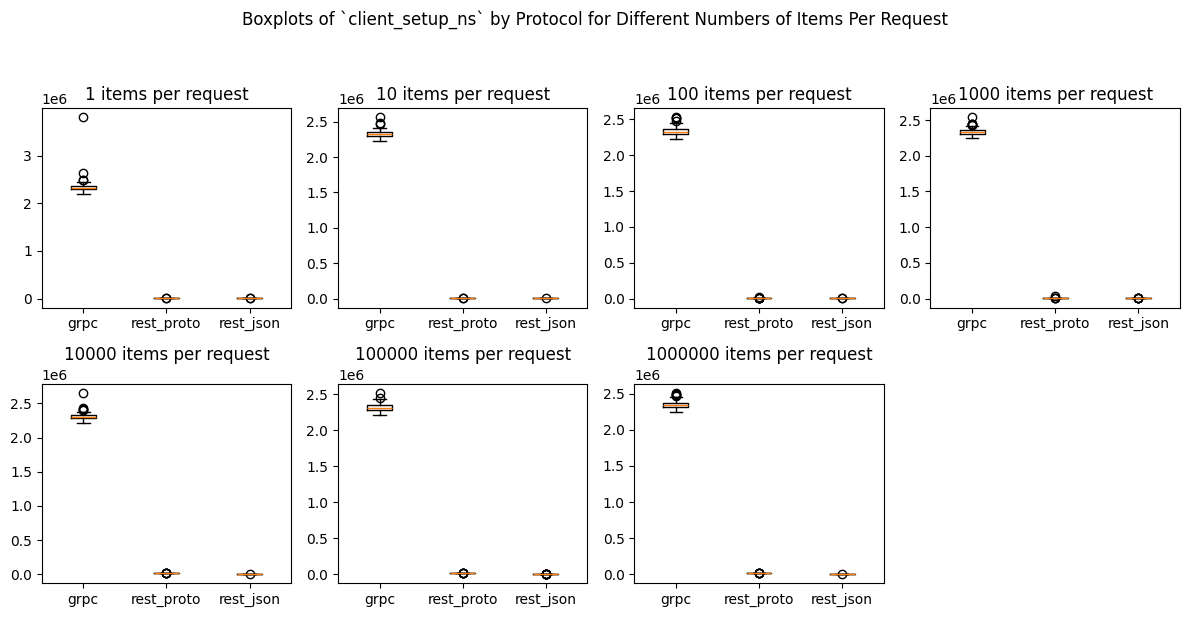

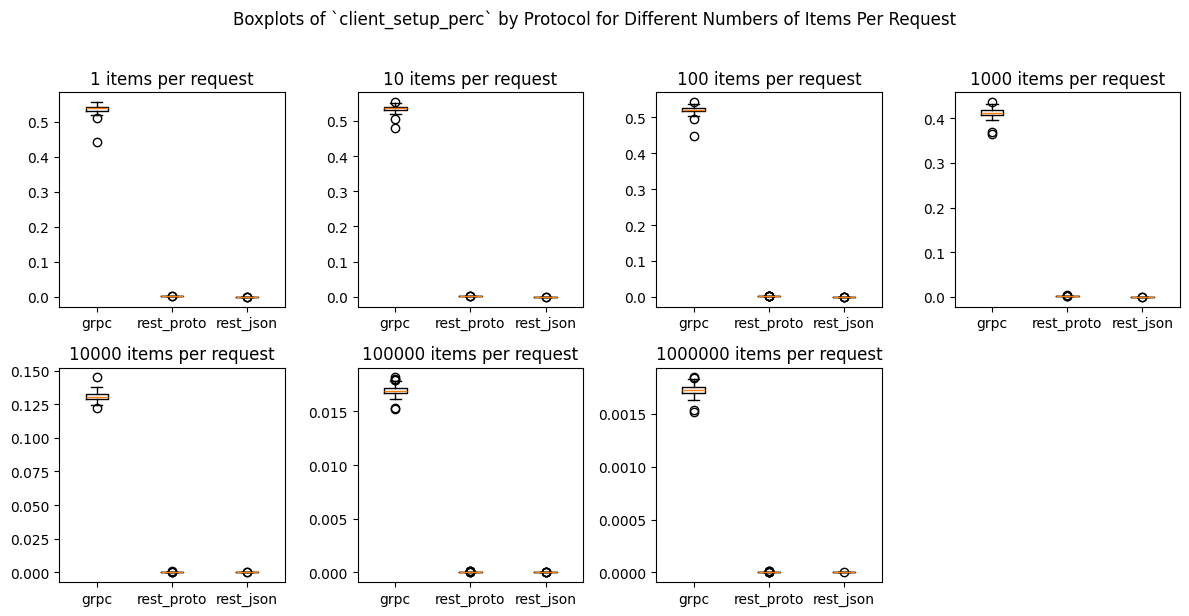

In [16]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='client_setup_ns')
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='client_setup_perc')

Because REST API only build the connection when the request is being sent, it does nothing during the set up phase.

In contrast, the set up phase actually measures the time for gRPC to build the connection between server and client, which is constantly around 2500 miliseconds.


#### uplink_latency

In [17]:
generate_desc_stats(df_latency, col='uplink_latency_ns')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,uplink_latency_ns,1547161.25,276397.426794,67270.75,1414500,4240125,100
1,grpc,10,uplink_latency_ns,1519172.07,72498.630352,52353.75,1426584,2038167,100
2,grpc,100,uplink_latency_ns,1523806.26,85584.434073,51458.50,1424667,2220042,100
3,grpc,1000,uplink_latency_ns,1526292.48,69349.449047,60072.50,1433667,1996541,100
4,grpc,10000,uplink_latency_ns,1512430.71,78243.593308,56323.25,1444291,2145666,100
5,grpc,100000,uplink_latency_ns,1512352.06,73445.276326,50614.50,1399291,2065792,100
6,grpc,1000000,uplink_latency_ns,1530302.09,168452.604074,76573.00,1378584,3015875,100
7,rest_json,1,uplink_latency_ns,5664043.31,93302.207552,127875.75,5487625,5963708,100
8,rest_json,10,uplink_latency_ns,5636346.33,93483.344778,127386.00,5454875,5873125,100
9,rest_json,100,uplink_latency_ns,5629940.36,128509.022295,136801.50,5307209,6268833,100


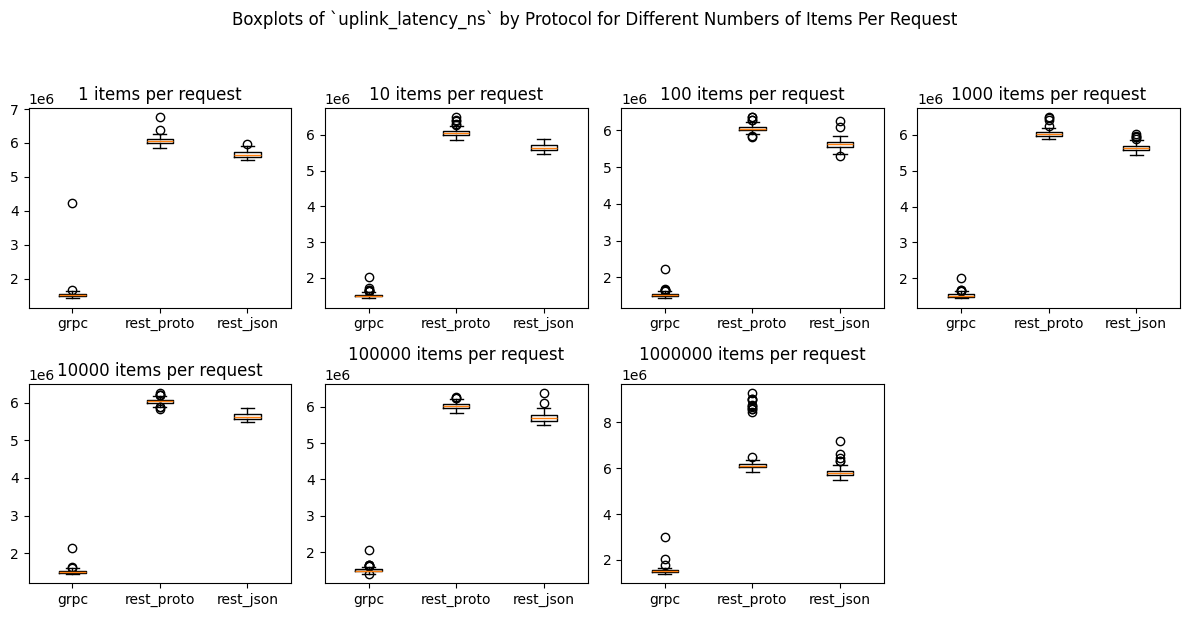

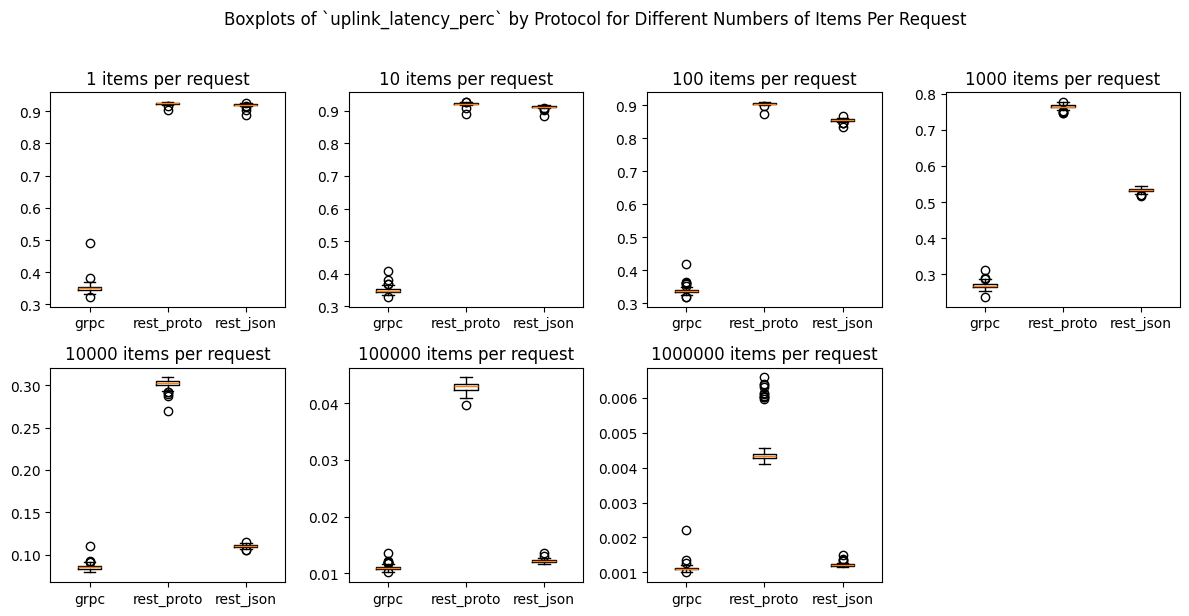

In [18]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='uplink_latency_ns')
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='uplink_latency_perc')

In this stage, gRPC only needs to serialise and send the bytes, which takes constantly around 1500 miliseconds regardless of response size.

In this stage, REST API needs to build the connection between server, serialse the message, and send the message.
- We can see that time required for REST with Protobuf and REST API is similar, at around 6k milliseconds.
- The time is also constant.

#### request_latency

In [19]:
generate_desc_stats(df_latency, col='request_latency_ns')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,request_latency_ns,3896819.55,428451.672399,92198.25,3701125,8048000,100
1,grpc,10,request_latency_ns,3842957.48,97329.988796,95500.25,3707791,4436625,100
2,grpc,100,request_latency_ns,3862522.06,108144.498368,104843.50,3724500,4576458,100
3,grpc,1000,request_latency_ns,3863455.43,84937.735635,95697.25,3708792,4347958,100
4,grpc,10000,request_latency_ns,3821264.95,98964.407497,84729.75,3682333,4511333,100
5,grpc,100000,request_latency_ns,3830353.74,95258.012861,79062.50,3681583,4409125,100
6,grpc,1000000,request_latency_ns,3879167.95,173382.830253,119365.00,3628334,5275833,100
7,rest_json,1,request_latency_ns,5665212.03,93300.832472,127739.25,5488792,5964833,100
8,rest_json,10,request_latency_ns,5637512.51,93479.075257,127354.00,5456042,5874292,100
9,rest_json,100,request_latency_ns,5631114.99,128511.929009,136822.50,5308375,6269958,100


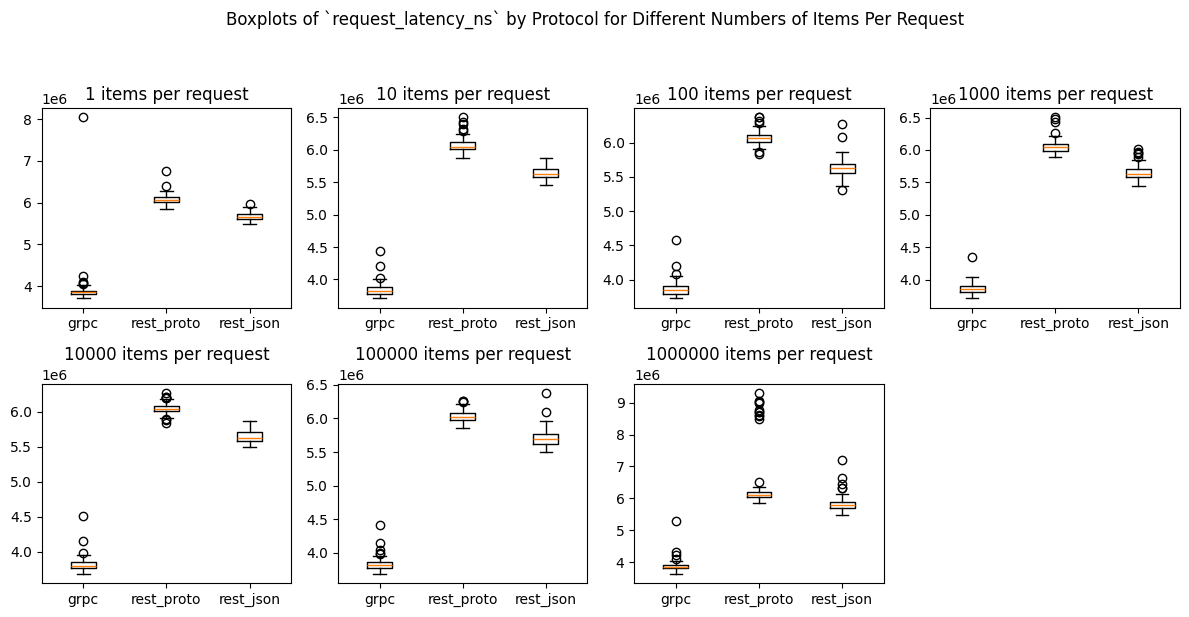

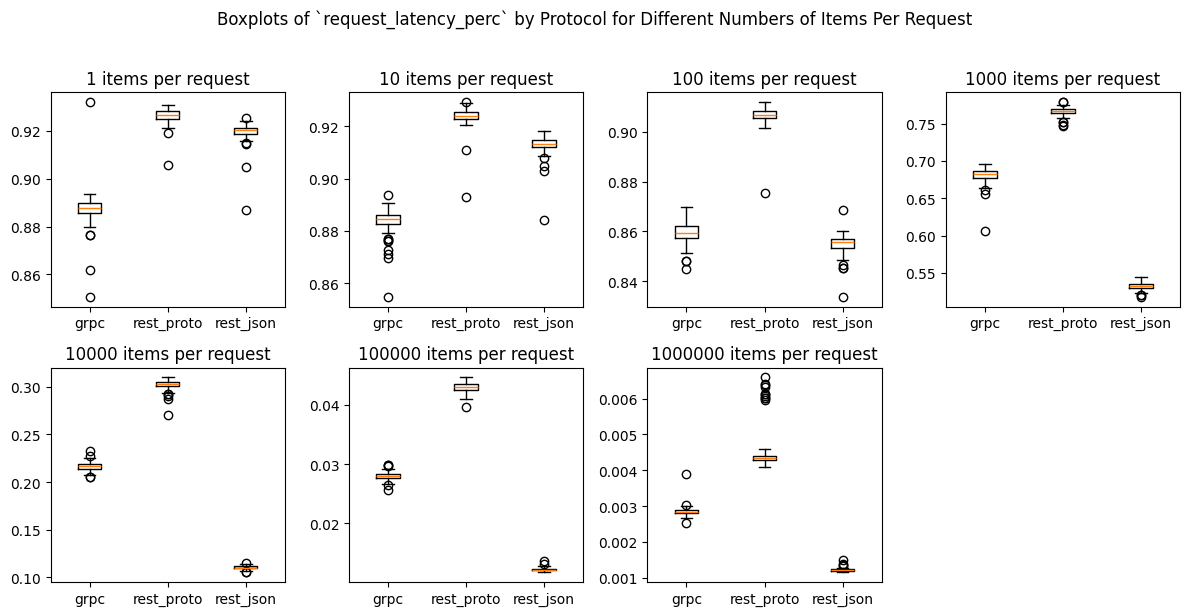

In [20]:
boxplots_by_size(df_latency, col='request_latency_ns')
boxplots_by_size(df_latency, col='request_latency_perc')

### Server phase

#### server_processing_ns

In [21]:
generate_desc_stats(df_latency, col='server_processing_ns')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,server_processing_ns,1.327188e+05,2.838965e+04,22718.25,106667,314250,100
1,grpc,10,server_processing_ns,1.470088e+05,2.259964e+04,13010.50,118541,292542,100
2,grpc,100,server_processing_ns,2.449942e+05,1.921909e+04,16594.25,219208,361500,100
3,grpc,1000,server_processing_ns,1.176638e+06,6.821676e+04,23604.00,1132708,1741083,100
4,grpc,10000,server_processing_ns,1.079093e+07,2.601720e+05,173937.50,10539917,11957375,100
5,grpc,100000,server_processing_ns,1.062646e+08,2.219537e+06,591541.25,104167583,120778125,100
6,grpc,1000000,server_processing_ns,1.098976e+09,1.984624e+07,18964562.25,1082277458,1222429500,100
7,rest_json,1,server_processing_ns,2.996433e+05,3.921713e+05,8156.00,246292,4177667,100
8,rest_json,10,server_processing_ns,3.167808e+05,2.810503e+05,8697.75,270833,3091875,100
9,rest_json,100,server_processing_ns,5.330342e+05,2.722852e+05,11948.00,480291,3221292,100


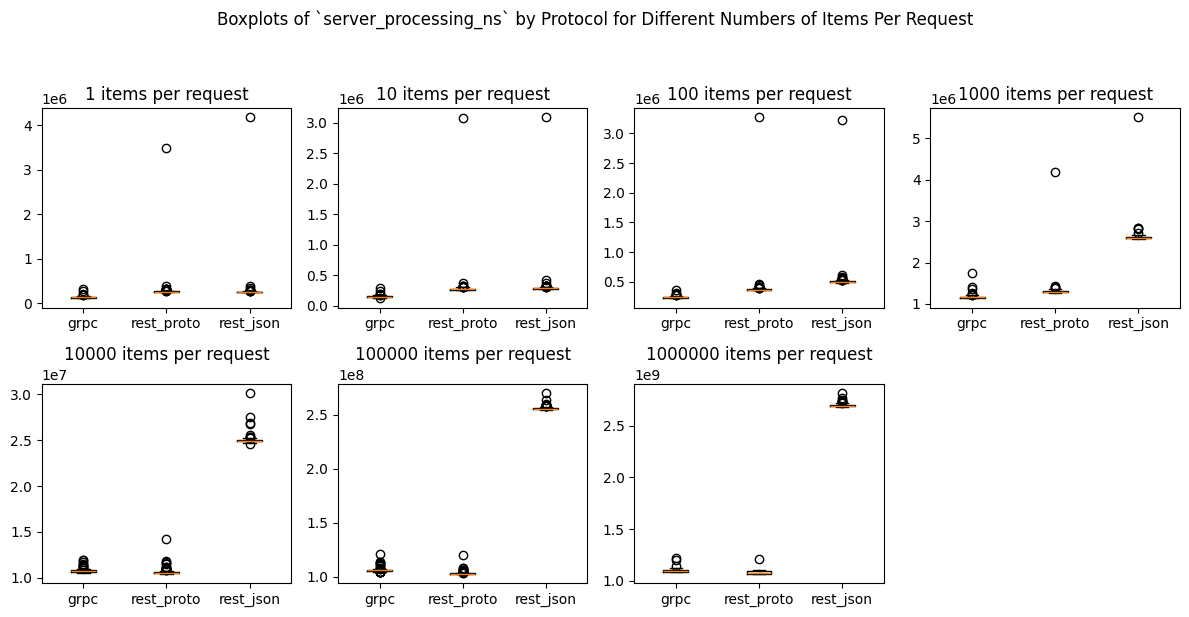

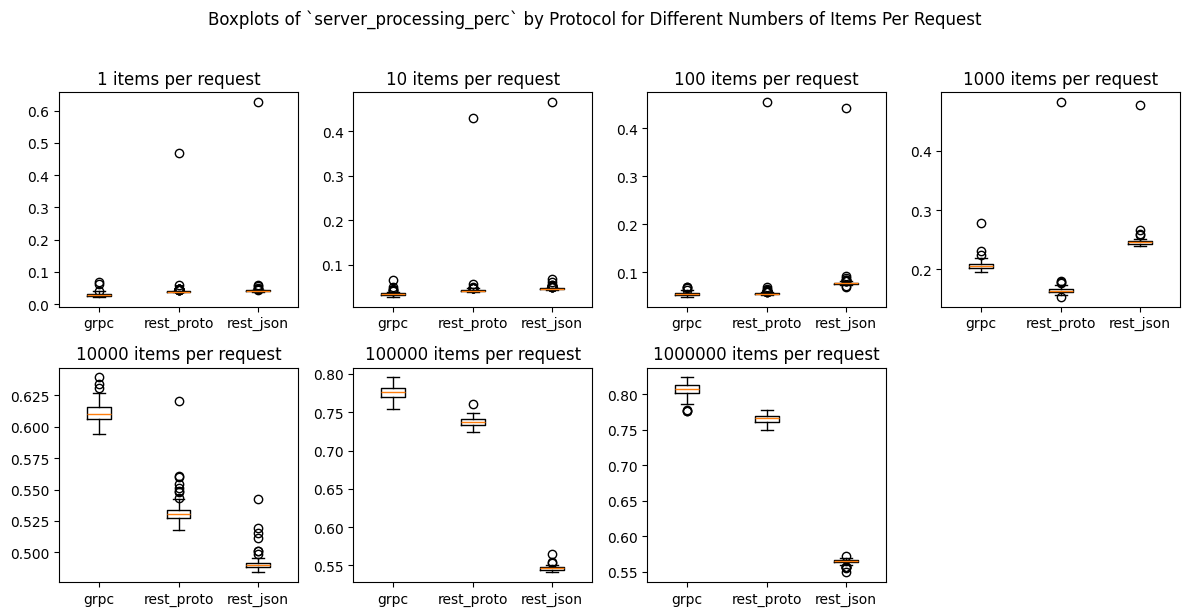

In [22]:
boxplots_by_size(df_latency, col='server_processing_ns')
boxplots_by_size(df_latency, col='server_processing_perc')

When request size is small (i.e., between 1-100 items), the time required to process at server is similar at around 1k milliseconds. Then, the time required to process at server grows in proportion to the size of response object. The unit of time taken to serialise and send per item is higher via Json than protobuf. 

#### items_per_s_server

In [23]:
generate_desc_stats(df_latency, col='items_per_s_server')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,items_per_s_server,7748.664125,1088.951100,1439.973773,3182.179793,9374.970703,100
1,grpc,10,items_per_s_server,69178.308919,8018.283139,6214.487346,34183.125842,84358.998153,100
2,grpc,100,items_per_s_server,410290.159039,27677.956161,28310.900674,276625.172891,456187.730375,100
3,grpc,1000,items_per_s_server,851987.212189,37089.136763,17426.168239,574355.157106,882840.061163,100
4,grpc,10000,items_per_s_server,927206.856872,21083.646426,15132.116055,836303.954672,948774.074786,100
5,grpc,100000,items_per_s_server,941423.434953,18230.064138,5281.463878,827964.501022,959991.555146,100
6,grpc,1000000,items_per_s_server,910213.394938,15401.076359,15756.892595,818043.085511,923977.481567,100
7,rest_json,1,items_per_s_server,3818.635607,422.269186,124.248522,239.368049,4060.221201,100
8,rest_json,10,items_per_s_server,34454.423733,3719.913249,1078.589110,3234.283404,36923.122367,100
9,rest_json,100,items_per_s_server,196288.898473,18150.597317,4747.275377,31043.444680,208207.107774,100


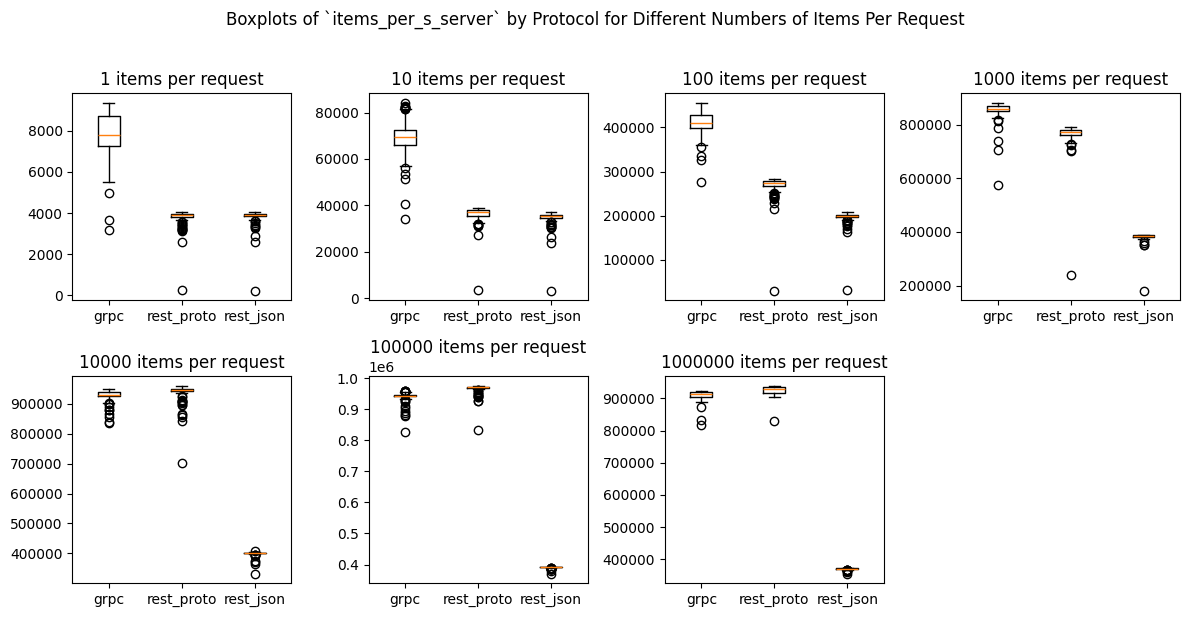

In [24]:
boxplots_by_size(df_latency, col='items_per_s_server')

#### kb_per_s_server

In [25]:
generate_desc_stats(df_latency, col='kb_per_s_server')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,kb_per_s_server,756.705481,106.342881,140.622439,310.759745,915.524483,100
1,grpc,10,kb_per_s_server,6755.694230,783.035463,606.883530,3338.195883,8238.183413,100
2,grpc,100,kb_per_s_server,40067.398344,2702.925406,2764.736394,27014.177040,44549.583044,100
3,grpc,1000,kb_per_s_server,83201.876190,3621.986012,1701.774242,56089.370811,86214.849723,100
4,grpc,10000,kb_per_s_server,90547.544616,2058.949846,1477.745709,81670.308073,92653.718241,100
5,grpc,100000,kb_per_s_server,91935.882320,1780.279701,515.767957,80855.908303,93749.175307,100
6,grpc,1000000,kb_per_s_server,88888.026849,1504.011363,1538.759042,79887.020069,90232.175934,100
7,rest_json,1,kb_per_s_server,962.117174,106.392041,31.304803,60.309528,1022.985420,100
8,rest_json,10,kb_per_s_server,8287.231021,894.740853,259.430174,777.933596,8881.020546,100
9,rest_json,100,kb_per_s_server,46988.571956,4344.976485,1136.425403,7431.327729,49841.609696,100


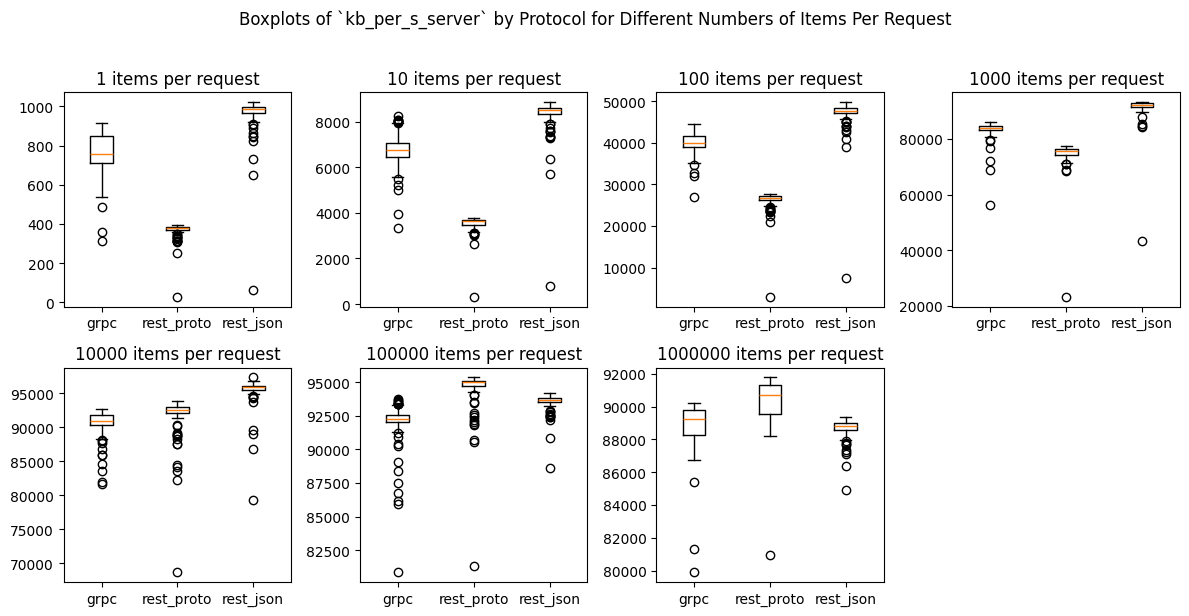

In [26]:
boxplots_by_size(df_latency, col='kb_per_s_server')

### Response phase

#### response_latency_ns

In [27]:
generate_desc_stats(df_latency, col='response_latency_ns')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,response_latency_ns,3.598433e+05,2.097671e+04,33603.75,321208,429542,100
1,grpc,10,response_latency_ns,3.585271e+05,1.829546e+04,23666.25,321750,414834,100
2,grpc,100,response_latency_ns,3.865829e+05,1.906536e+04,25729.50,338625,431667,100
3,grpc,1000,response_latency_ns,6.347129e+05,4.372775e+04,52989.50,556791,786750,100
4,grpc,10000,response_latency_ns,3.044049e+06,1.492894e+05,197979.75,2757792,3449334,100
5,grpc,100000,response_latency_ns,2.689180e+07,1.259486e+06,1693791.75,24300709,30453000,100
6,grpc,1000000,response_latency_ns,2.595646e+08,1.509810e+07,14625573.00,231750042,316325666,100
7,rest_json,1,response_latency_ns,1.947396e+05,3.659771e+05,13000.00,-3426125,255250,100
8,rest_json,10,response_latency_ns,2.214117e+05,2.578269e+05,16469.50,-2323291,298334,100
9,rest_json,100,response_latency_ns,4.218103e+05,2.462496e+05,16573.00,-2009125,515500,100


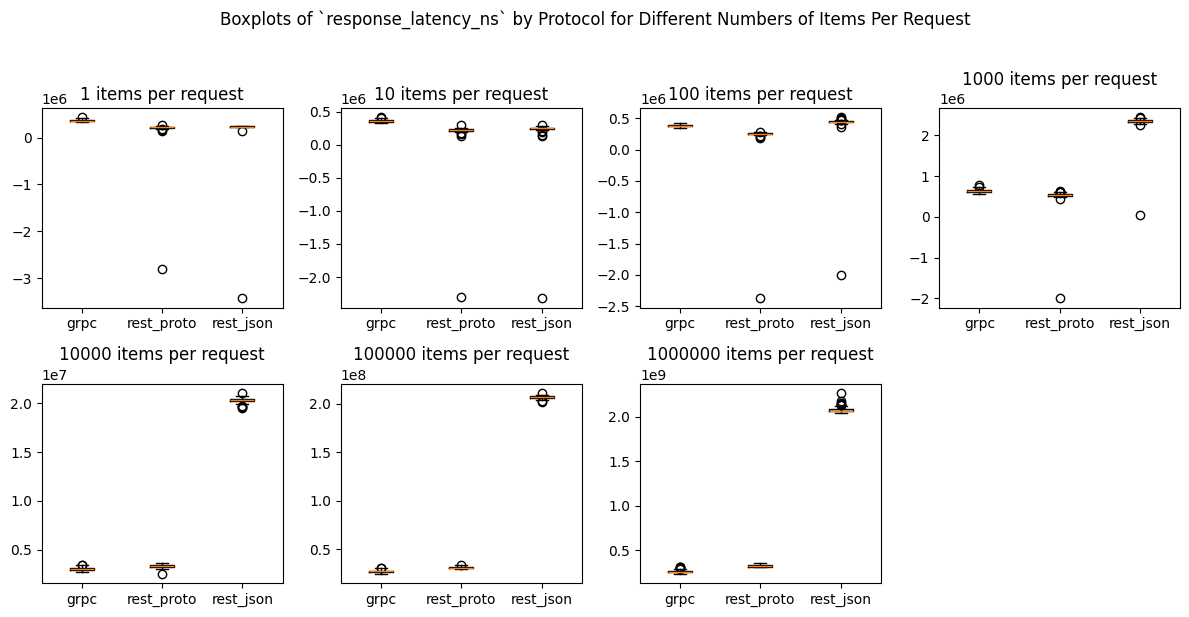

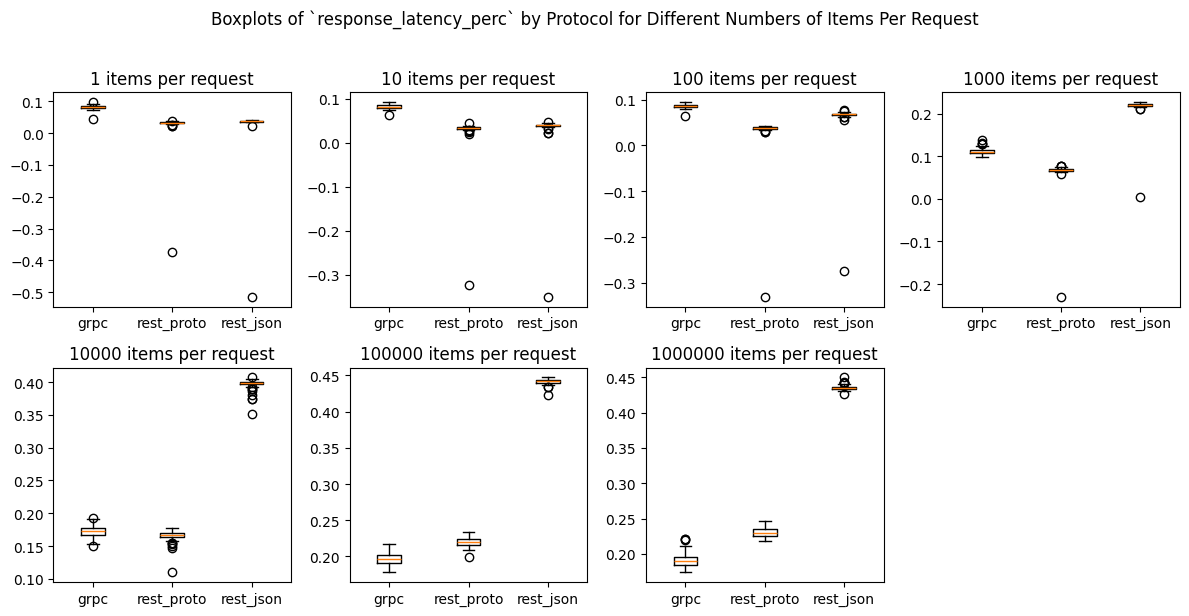

In [28]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='response_latency_ns')
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='response_latency_perc')

#### items_per_s_response

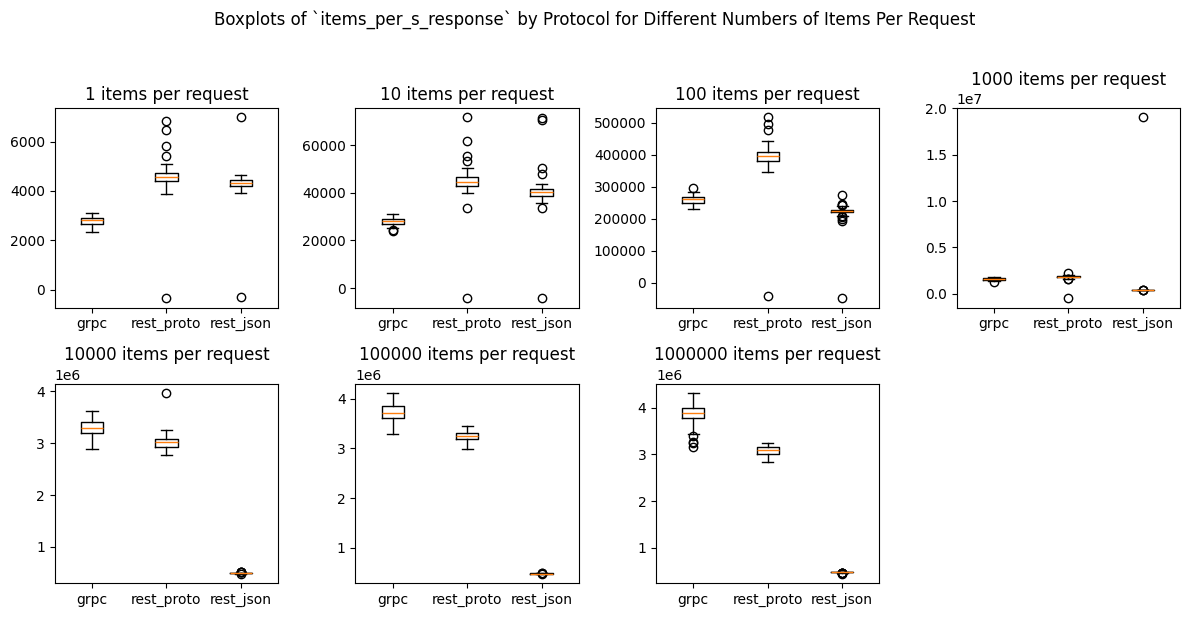

In [29]:
generate_desc_stats(df_latency, col='items_per_s_response')
boxplots_by_size(df_latency, col='items_per_s_response')

#### kb_per_s_response

In [30]:
generate_desc_stats(df_latency, col='kb_per_s_response')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,kb_per_s_response,272.275688,15.462544,25.481259,227.349712,3.040281e+02,100
1,grpc,10,kb_per_s_response,2730.593482,134.389094,181.317501,2354.104292,3.035159e+03,100
2,grpc,100,kb_per_s_response,25321.809673,1239.805201,1683.259642,22623.052029,2.883906e+04,100
3,grpc,1000,kb_per_s_response,154551.520542,10196.985192,13002.256800,124126.151891,1.753912e+05,100
4,grpc,10000,kb_per_s_response,321559.735944,15465.522816,21141.759151,283116.247948,3.541103e+05,100
5,grpc,100000,kb_per_s_response,363921.959684,16791.131811,23004.410878,320678.586675,4.018658e+05,100
6,grpc,1000000,kb_per_s_response,377423.347296,20801.442010,21493.046021,308720.601888,4.213861e+05,100
7,rest_json,1,kb_per_s_response,1081.968855,141.799930,60.456500,-73.538801,1.759867e+03,100
8,rest_json,10,kb_per_s_response,9716.698050,1593.743049,638.633735,-1035.287201,1.720609e+04,100
9,rest_json,100,kb_per_s_response,53068.135888,6953.072977,1966.406209,-11914.876657,6.597657e+04,100


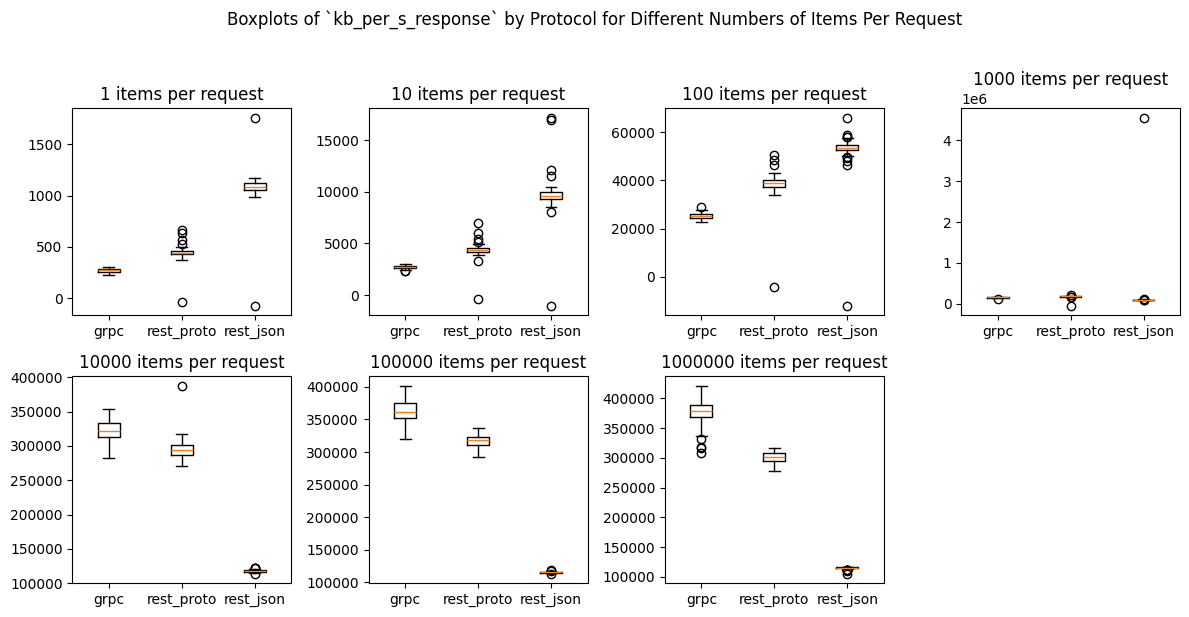

In [31]:
boxplots_by_size(df_latency, col='kb_per_s_response')

### Total Run time

In [32]:
generate_desc_stats(df_latency, col='total_runtime_ns')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,total_runtime_ns,4.389382e+06,4.398204e+05,96322.75,4179000,8633708,100
1,grpc,10,total_runtime_ns,4.348493e+06,1.034929e+05,96239.75,4216166,5004500,100
2,grpc,100,total_runtime_ns,4.494099e+06,1.149358e+05,107073.00,4349792,5276583,100
3,grpc,1000,total_runtime_ns,5.674806e+06,1.275415e+05,102260.00,5475041,6437083,100
4,grpc,10000,total_runtime_ns,1.765625e+07,3.261609e+05,278062.50,17280708,19386958,100
5,grpc,100000,total_runtime_ns,1.369868e+08,2.652270e+06,1963198.00,132773542,152852750,100
6,grpc,1000000,total_runtime_ns,1.362419e+09,2.544249e+07,22850833.75,1323292250,1503158541,100
7,rest_json,1,total_runtime_ns,6.159595e+06,1.073516e+05,136770.75,5973083,6657333,100
8,rest_json,10,total_runtime_ns,6.175705e+06,1.038043e+05,122802.75,5991708,6634375,100
9,rest_json,100,total_runtime_ns,6.585960e+06,1.432111e+05,123041.75,6241875,7294417,100


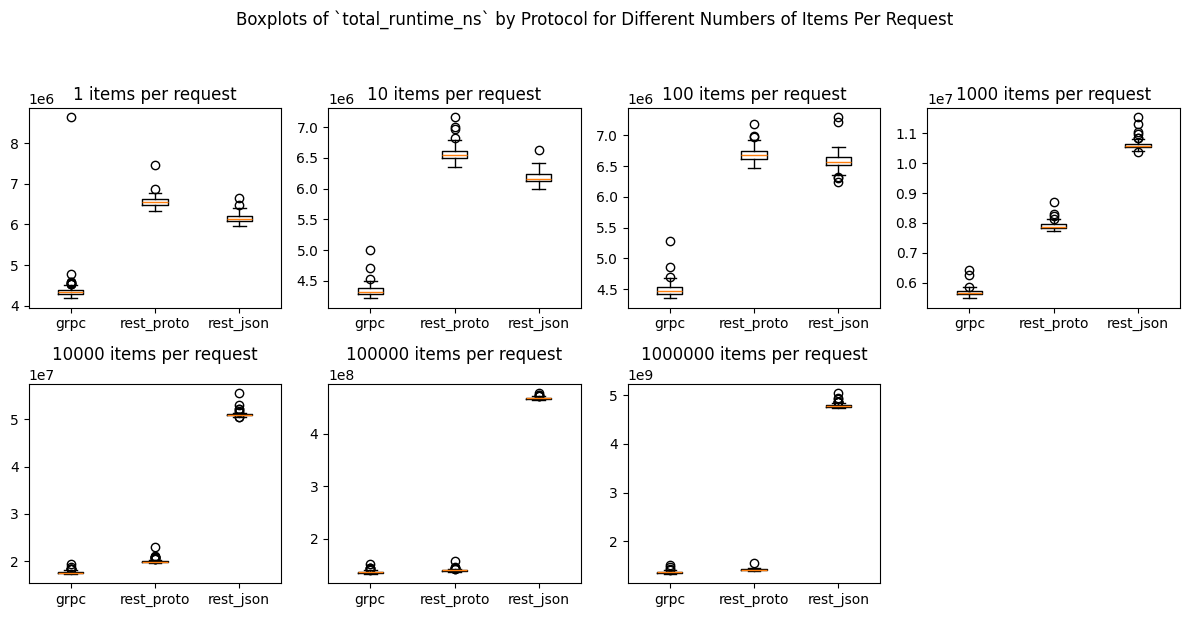

In [33]:
boxplots_by_size(df_latency, col='total_runtime_ns')

#### items_per_s_total_runtime

In [34]:
generate_desc_stats(df_latency, col='items_per_s_total_runtime')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,items_per_s_total_runtime,229.040333,12.506080,5.133913,115.825089,239.291697,100
1,grpc,10,items_per_s_total_runtime,2300.854059,51.326118,51.295369,1998.201619,2371.823121,100
2,grpc,100,items_per_s_total_runtime,22264.689750,526.310884,533.196882,18951.658678,22989.605020,100
3,grpc,1000,items_per_s_total_runtime,176300.185443,3723.938778,3192.386862,155349.868877,182647.034059,100
4,grpc,10000,items_per_s_total_runtime,566555.574082,10056.466153,8974.130980,515810.680562,578679.993898,100
5,grpc,100000,items_per_s_total_runtime,730255.105042,13458.205092,10522.587040,654224.408786,753162.102130,100
6,grpc,1000000,items_per_s_total_runtime,734230.731234,13120.801003,12371.351325,665265.820420,755690.966980,100
7,rest_json,1,items_per_s_total_runtime,162.396082,2.768793,3.615687,150.210302,167.417731,100
8,rest_json,10,items_per_s_total_runtime,1619.694358,26.816575,32.167918,1507.300989,1668.973188,100
9,rest_json,100,items_per_s_total_runtime,15190.689431,319.760146,283.849139,13709.114793,16020.827075,100


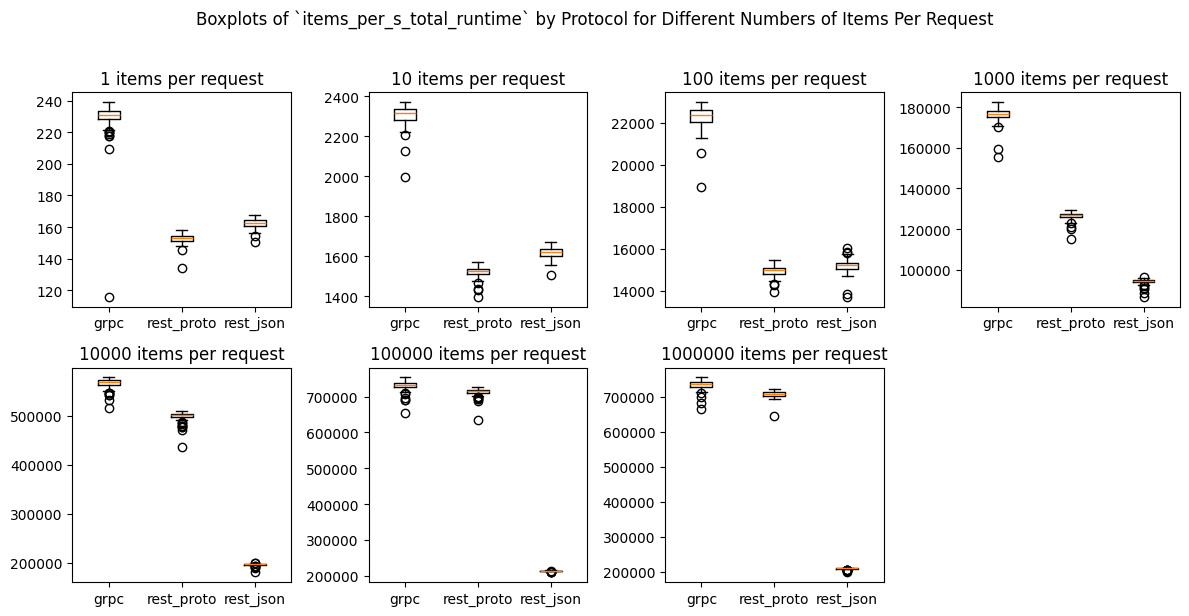

In [35]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='items_per_s_total_runtime')

#### kb_per_s_total_runtime

In [36]:
generate_desc_stats(df_latency, col='kb_per_s_total_runtime')

,protocol,size,variable,mean,std,IQR,min,max,count
0,grpc,1,kb_per_s_total_runtime,22.367220,1.221297,0.501359,11.311044,23.368330,100
1,grpc,10,kb_per_s_total_runtime,224.692779,5.012316,5.009313,195.136877,231.623352,100
2,grpc,100,kb_per_s_total_runtime,2174.286108,51.397547,52.070008,1850.747918,2245.078615,100
3,grpc,1000,kb_per_s_total_runtime,17216.814985,363.665896,311.756529,15170.885633,17836.624420,100
4,grpc,10000,kb_per_s_total_runtime,55327.692781,982.076773,876.379978,50372.136774,56511.718154,100
5,grpc,100000,kb_per_s_total_runtime,71313.975102,1314.277841,1027.596391,63889.102420,73550.986536,100
6,grpc,1000000,kb_per_s_total_runtime,71702.219847,1281.328223,1208.139778,64967.365275,73797.945994,100
7,rest_json,1,kb_per_s_total_runtime,40.916200,0.697606,0.910984,37.845955,42.181420,100
8,rest_json,10,kb_per_s_total_runtime,389.580782,6.450120,7.737264,362.547103,401.433688,100
9,rest_json,100,kb_per_s_total_runtime,3636.419629,76.545708,67.949160,3281.753232,3835.141935,100


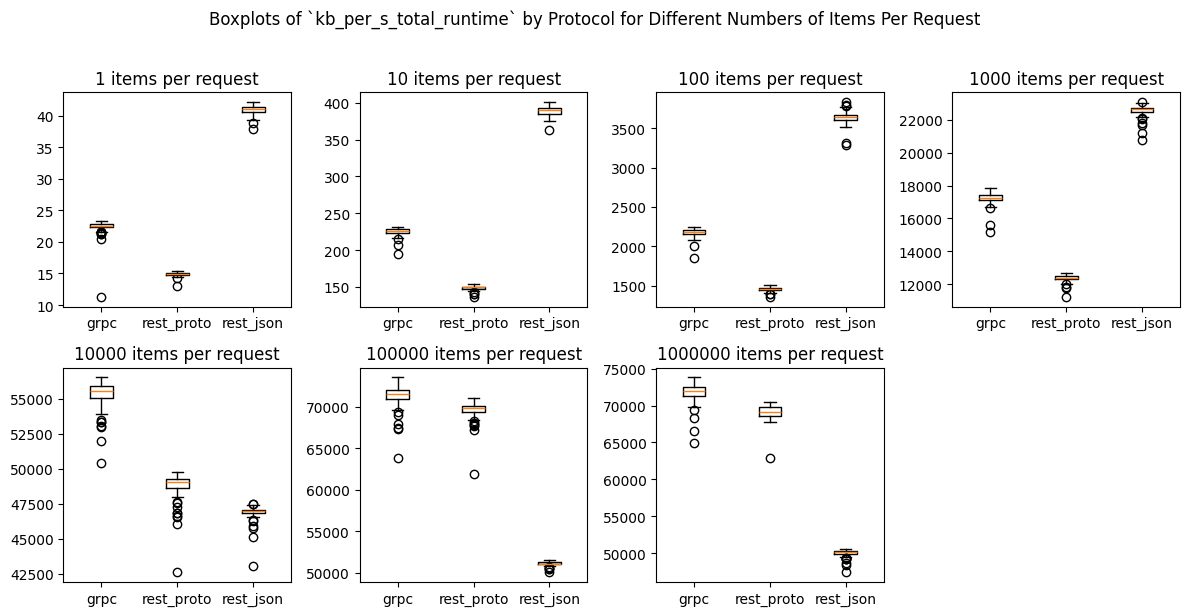

In [37]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='kb_per_s_total_runtime')

## Kb per second

### Summary table

In [38]:
summary_df = df_latency.groupby(['protocol', 'size']).agg(
    count=('total_runtime_ns', 'count'),
    mean_total_runtime_ns=('total_runtime_ns', 'mean'),
    mean_items_per_s_total_runtime=('items_per_s_total_runtime', 'mean'),
    mean_kb_per_s_total_runtime=('kb_per_s_total_runtime', 'mean'),
    mean_request_latency_ns=('request_latency_ns', 'mean'),
    mean_server_processing_ns=('server_processing_ns', 'mean'),
    mean_response_latency_ns=('response_latency_ns', 'mean')
).reset_index()
summary_df

,protocol,size,count,mean_total_runtime_ns,mean_items_per_s_total_runtime,mean_kb_per_s_total_runtime,mean_request_latency_ns,mean_server_processing_ns,mean_response_latency_ns
0,grpc,1,100,4.389382e+06,229.040333,22.367220,3896819.55,1.327188e+05,3.598433e+05
1,grpc,10,100,4.348493e+06,2300.854059,224.692779,3842957.48,1.470088e+05,3.585271e+05
2,grpc,100,100,4.494099e+06,22264.689750,2174.286108,3862522.06,2.449942e+05,3.865829e+05
3,grpc,1000,100,5.674806e+06,176300.185443,17216.814985,3863455.43,1.176638e+06,6.347129e+05
4,grpc,10000,100,1.765625e+07,566555.574082,55327.692781,3821264.95,1.079093e+07,3.044049e+06
5,grpc,100000,100,1.369868e+08,730255.105042,71313.975102,3830353.74,1.062646e+08,2.689180e+07
6,grpc,1000000,100,1.362419e+09,734230.731234,71702.219847,3879167.95,1.098976e+09,2.595646e+08
7,rest_json,1,100,6.159595e+06,162.396082,40.916200,5665212.03,2.996433e+05,1.947396e+05
8,rest_json,10,100,6.175705e+06,1619.694358,389.580782,5637512.51,3.167808e+05,2.214117e+05
9,rest_json,100,100,6.585960e+06,15190.689431,3636.419629,5631114.99,5.330342e+05,4.218103e+05


### speed line chart

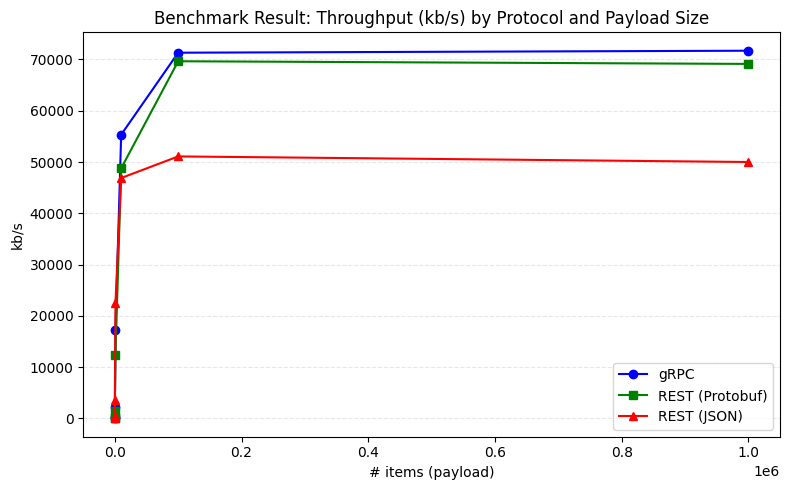

In [39]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_kb_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

# plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('kb/s')
plt.title('Benchmark Result: Throughput (kb/s) by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


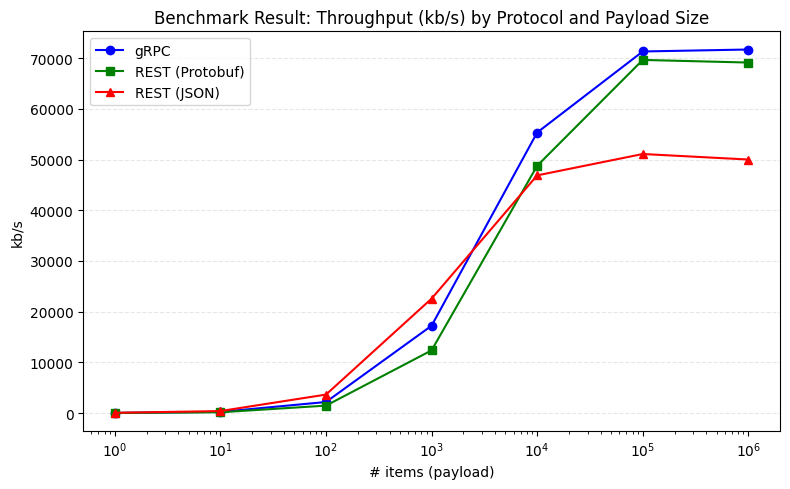

In [40]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_kb_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('kb/s')
plt.title('Benchmark Result: Throughput (kb/s) by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


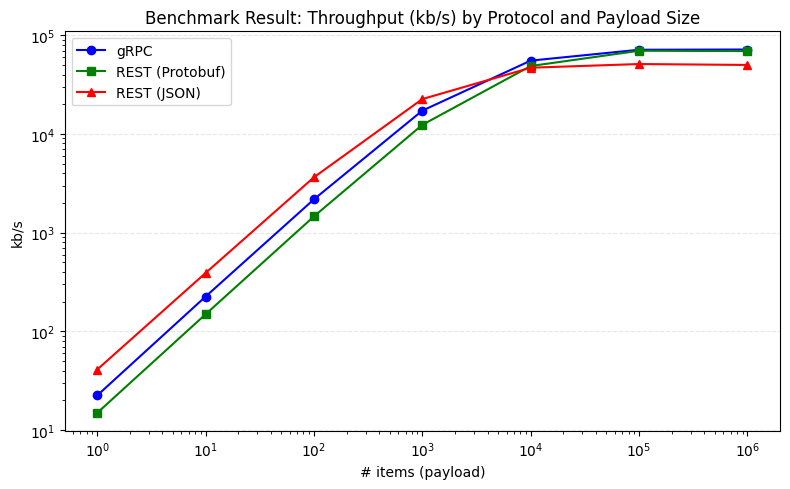

In [41]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_kb_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.yscale('log')
plt.ylabel('kb/s')
plt.title('Benchmark Result: Throughput (kb/s) by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

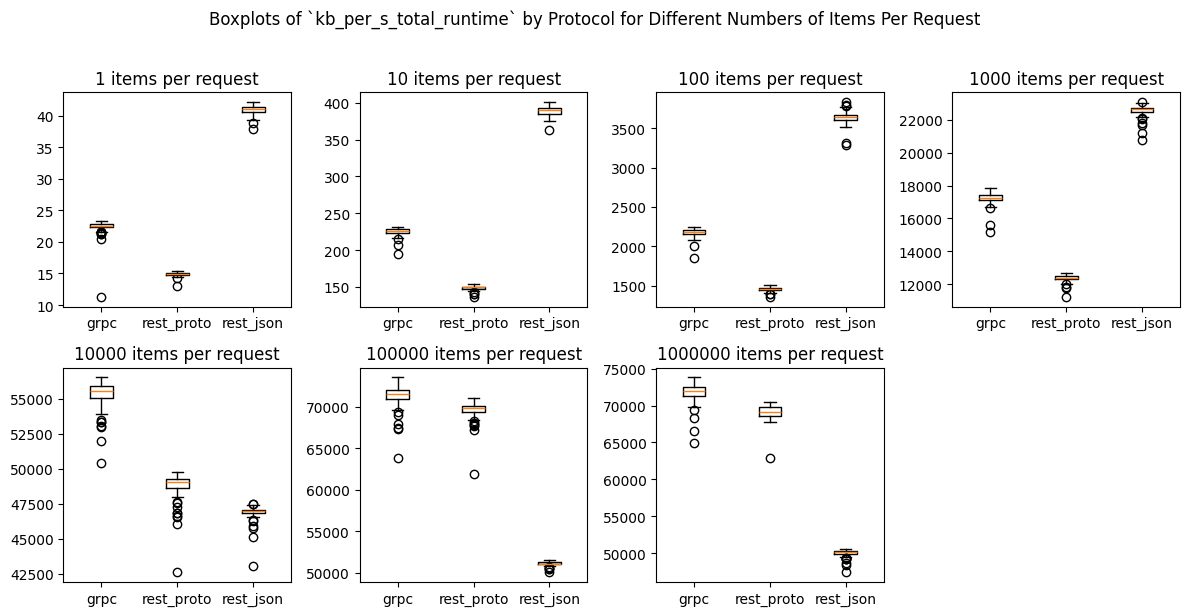

In [42]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='kb_per_s_total_runtime')

#### Mixed Model

In [43]:
from statsmodels.regression.mixed_linear_model import MixedLM

In [44]:
# 1) create a single grouping column that uniquely identifies each protocol×size cell
df_latency['batch'] = df_latency['protocol'].astype(str) + "_" + df_latency['size'].astype(str)

# 2) log‐transform throughput
df_latency['log_throughput'] = np.log10(df_latency['kb_per_s_total_runtime'])

# 3) fit a random‐intercept model, with one intercept per cell
md = MixedLM.from_formula(
    "log_throughput ~ C(protocol)*C(size)",
    groups="batch",
    data=df_latency
)
mres = md.fit()
print(mres.summary())

                          Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          log_throughput
No. Observations:            2100             Method:                      REML          
No. Groups:                  21               Scale:                       0.0001        
Min. group size:             100              Log-Likelihood:              6559.4547     
Max. group size:             100              Converged:                   Yes           
Mean group size:             100.0                                                       
-----------------------------------------------------------------------------------------
                                             Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                     1.349     0.010 133.147 0.000  1.329  1.369
C(protocol)[T.rest_json]            

/Users/haochen/projects/benchmark_grpc_proto_rest_json/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Plot

#### Compare protocols within each batch

##### Function Definition

In [45]:
from statsmodels.stats.multitest import multipletests

In [46]:
def mixed_model_t_test(size, model_results=mres):
    res = {}
    pvals_keys = []
    pvals = []
    names = model_results.model.exog_names

    # Compare gRPC vs REST-Proto
    r = np.zeros((1, len(names)))
    r[0, names.index(f'C(protocol)[T.rest_proto]')] = 1.0
    r[0, names.index(f'C(protocol)[T.rest_proto]:C(size)[T.{size}]')] = 1.0

    t1 = model_results.t_test(r)
    print(f"=== gRPC vs REST-Proto at size={size} ===")
    print(t1.summary())

    res['grpc_vs_rest_proto'] = t1
    pvals_keys.append('grpc_vs_rest_proto')
    pvals.append(t1.pvalue)

    # Compare gRPC vs REST-Json
    r = np.zeros((1, len(names)))
    r[0, names.index(f'C(protocol)[T.rest_json]')] = 1.0
    r[0, names.index(f'C(protocol)[T.rest_json]:C(size)[T.{size}]')] = 1.0

    t2 = model_results.t_test(r)
    print(f"=== gRPC vs REST-Json at size={size} ===")
    print(t2.summary())

    res['grpc_vs_rest_json'] = t2
    pvals_keys.append('grpc_vs_rest_json')
    pvals.append(t2.pvalue)
   

    # Compare REST_proto vs REST-Json
    r = np.zeros((1, len(names)))
    r[0, names.index('C(protocol)[T.rest_proto]')] = -1.0
    r[0, names.index('C(protocol)[T.rest_json]')] =  1.0
    r[0, names.index(f'C(protocol)[T.rest_proto]:C(size)[T.{size}]')] = -1.0
    r[0, names.index(f'C(protocol)[T.rest_json]:C(size)[T.{size}]')] =  1.0

    t3 = model_results.t_test(r)
    print(f"=== REST-JSON vs REST-Proto at size={size} ===")
    print(t3.summary())

    res['rest_proto_vs_rest_json'] = t3
    pvals_keys.append('rest_proto_vs_rest_json')
    pvals.append(t3.pvalue)

    reject, pvals_adj, _, _ = multipletests(
        pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
    )

    for i in range(len(pvals_adj)):
        print(f'Adjusted p_value of {pvals_keys[i]}: {pvals_adj[i]}; rejected: {reject[i]}')
    
    return res

In [47]:
def mixed_model_t_test_at_size_1(model_results=mres):
    model_results=mres
    names = model_results.model.exog_names

    t_res_1 = {}
    pvals_keys = []
    pvals = []

    # Compare gRPC vs rest_proto
    r = np.zeros((1, len(names)))

    r[0, names.index('C(protocol)[T.rest_proto]')] = 1.0

    t_res_1['grpc_vs_rest_proto'] = mres.t_test(r)
    print("=== gRPC vs REST-Proto @ size=1 ===")
    print(t_res_1['grpc_vs_rest_proto'].summary())
    pvals_keys.append('grpc_vs_rest_proto')
    pvals.append(t_res_1['grpc_vs_rest_proto'].pvalue)

    # Compare gRPC vs rest_json
    r = np.zeros((1, len(names)))

    r[0, names.index('C(protocol)[T.rest_json]')] = 1.0

    t_res_1['grpc_vs_rest_json'] = mres.t_test(r)
    print("=== gRPC vs REST-json @ size=1 ===")
    print(t_res_1['grpc_vs_rest_json'].summary())
    pvals_keys.append('grpc_vs_rest_json')
    pvals.append(t_res_1['grpc_vs_rest_json'].pvalue)

    # Compare REST_proto vs REST-Json at size 1
    r = np.zeros((1, len(names)))
    r[0, names.index('C(protocol)[T.rest_proto]')] = -1.0
    r[0, names.index('C(protocol)[T.rest_json]')] =  1.0

    t_res_1['rest_proto_vs_rest_json'] = model_results.t_test(r)
    print(f"=== REST-JSON vs REST-Proto at size={1} ===")
    print(t_res_1['rest_proto_vs_rest_json'].summary())
    pvals_keys.append('rest_proto_vs_rest_json')
    pvals.append(t_res_1['rest_proto_vs_rest_json'].pvalue)

    reject, pvals_adj, _, _ = multipletests(
            pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
        )

    for i in range(len(pvals_adj)):
        print(f'{pvals_keys[i]}, adjusted p_value: {pvals_adj[i]}')

    return t_res_1

##### Run test

In [48]:
t_res_1 = mixed_model_t_test_at_size_1()

=== gRPC vs REST-Proto @ size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1761      0.014    -12.294      0.000      -0.204      -0.148
=== gRPC vs REST-json @ size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2631      0.014     18.370      0.000       0.235       0.291
=== REST-JSON vs REST-Proto at size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.4

In [49]:
t_res_10 = mixed_model_t_test(10)

=== gRPC vs REST-Proto at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1794      0.014    -12.524      0.000      -0.207      -0.151
=== gRPC vs REST-Json at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2391      0.014     16.688      0.000       0.211       0.267
=== REST-JSON vs REST-Proto at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0           

In [50]:
t_res_100 = mixed_model_t_test(100)

=== gRPC vs REST-Proto at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1730      0.014    -12.079      0.000      -0.201      -0.145
=== gRPC vs REST-Json at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2234      0.014     15.594      0.000       0.195       0.251
=== REST-JSON vs REST-Proto at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0        

In [51]:
t_res_1000 = mixed_model_t_test(1_000)

=== gRPC vs REST-Proto at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1439      0.014    -10.044      0.000      -0.172      -0.116
=== gRPC vs REST-Json at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1175      0.014      8.200      0.000       0.089       0.146
=== REST-JSON vs REST-Proto at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0     

In [52]:
t_res_10000 = mixed_model_t_test(10_000)

=== gRPC vs REST-Proto at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0548      0.014     -3.827      0.000      -0.083      -0.027
=== gRPC vs REST-Json at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0720      0.014     -5.024      0.000      -0.100      -0.044
=== REST-JSON vs REST-Proto at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0  

In [53]:
t_res_100000 = mixed_model_t_test(100_000)

=== gRPC vs REST-Proto at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0103      0.014     -0.716      0.474      -0.038       0.018
=== gRPC vs REST-Json at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1448      0.014    -10.106      0.000      -0.173      -0.117
=== REST-JSON vs REST-Proto at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [54]:
t_res_1000000 = mixed_model_t_test(1_000_000)

=== gRPC vs REST-Proto at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0158      0.014     -1.106      0.269      -0.044       0.012
=== gRPC vs REST-Json at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1565      0.014    -10.925      0.000      -0.185      -0.128
=== REST-JSON vs REST-Proto at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

#### Compare protocols overall

###### Define functions

In [55]:
def mixed_model_t_test_overall(mres=mres):
    names = mres.model.exog_names
    size_levels = [1, 10, 100, 1000, 10000, 100000, 1000000]
    K = len(size_levels)

    r = np.zeros((1, len(names)))

    for size in size_levels:
        if size == 1:
            term = 'C(protocol)[T.rest_proto]'
            r[0, names.index(term)] = 1.0
        else:
            term = f'C(protocol)[T.rest_proto]:C(size)[T.{size}]'
            r[0, names.index(term)] = 1.0 / K

    t_grpc_vs_rest_proto = mres.t_test(r)
    print(f"=== gRPC vs REST-Proto overall ===")
    print(t_grpc_vs_rest_proto.summary())

    # Compare gRPC vs REST-Proto
    r = np.zeros((1, len(names)))

    for size in size_levels:
        if size == 1:
            term = 'C(protocol)[T.rest_json]'
            r[0, names.index(term)] = 1.0
        else:
            term = f'C(protocol)[T.rest_json]:C(size)[T.{size}]'
            r[0, names.index(term)] = 1.0 / K

    t_grpc_vs_rest_json = mres.t_test(r)
    print(f"=== gRPC vs REST-JSON overall ===")
    print(t_grpc_vs_rest_json.summary())

    # 1×k_fe contrast for REST-Proto minus REST-JSON, averaged across sizes
    r = np.zeros((1, len(names)))

    # 1) main‐effect difference at size=1
    r[0, names.index('C(protocol)[T.rest_proto]')] =  -1.0
    r[0, names.index('C(protocol)[T.rest_json]')]  = 1.0

    # 2) add each interaction difference, weighted by 1/K
    for s in size_levels:
        if s == size_levels[0]:
            continue
        proto_term = f'C(protocol)[T.rest_proto]:C(size)[T.{s}]'
        json_term  = f'C(protocol)[T.rest_json]:C(size)[T.{s}]'
        r[0, names.index(proto_term)] =  -1.0 / K
        r[0, names.index(json_term)]  = 1.0 / K

    # 3) run the test
    t_rest_proto_vs_rest_json = mres.t_test(r)
    print("=== REST-Proto vs REST-JSON (averaged across payload sizes) ===")
    print(t_rest_proto_vs_rest_json.summary())

    res = {
        'grpc_vs_rest_proto': t_grpc_vs_rest_proto,
        'grpc_vs_rest_json': t_grpc_vs_rest_json,
        'rest_proto_vs_rest_json': t_grpc_vs_rest_json,
    }

    p_values = [v.pvalue for v in res.values()]
    p_value_keys = [k for k in res.keys()]

    reject, pvals_adj, _, _ = multipletests(
        p_values, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
    )

    for i in range(len(pvals_adj)):
        print(f'{p_value_keys[i]}, adjusted p_value: {pvals_adj[i]}')

    return res


In [56]:
t_res_res = mixed_model_t_test_overall()

=== gRPC vs REST-Proto overall ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1076      0.005    -19.877      0.000      -0.118      -0.097
=== gRPC vs REST-JSON overall ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0671      0.005     12.396      0.000       0.057       0.078
=== REST-Proto vs REST-JSON (averaged across payload sizes) ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

## Item per second

### summary_table

In [57]:
summary_df = df_latency.groupby(['protocol', 'size']).agg(
    count=('total_runtime_ns', 'count'),
    mean_total_runtime_ns=('total_runtime_ns', 'mean'),
    mean_items_per_s_total_runtime=('items_per_s_total_runtime', 'mean'),
    mean_kb_per_s_total_runtime=('kb_per_s_total_runtime', 'mean'),
    mean_request_latency_ns=('request_latency_ns', 'mean'),
    mean_server_processing_ns=('server_processing_ns', 'mean'),
    mean_response_latency_ns=('response_latency_ns', 'mean')
).reset_index()
summary_df

,protocol,size,count,mean_total_runtime_ns,mean_items_per_s_total_runtime,mean_kb_per_s_total_runtime,mean_request_latency_ns,mean_server_processing_ns,mean_response_latency_ns
0,grpc,1,100,4.389382e+06,229.040333,22.367220,3896819.55,1.327188e+05,3.598433e+05
1,grpc,10,100,4.348493e+06,2300.854059,224.692779,3842957.48,1.470088e+05,3.585271e+05
2,grpc,100,100,4.494099e+06,22264.689750,2174.286108,3862522.06,2.449942e+05,3.865829e+05
3,grpc,1000,100,5.674806e+06,176300.185443,17216.814985,3863455.43,1.176638e+06,6.347129e+05
4,grpc,10000,100,1.765625e+07,566555.574082,55327.692781,3821264.95,1.079093e+07,3.044049e+06
5,grpc,100000,100,1.369868e+08,730255.105042,71313.975102,3830353.74,1.062646e+08,2.689180e+07
6,grpc,1000000,100,1.362419e+09,734230.731234,71702.219847,3879167.95,1.098976e+09,2.595646e+08
7,rest_json,1,100,6.159595e+06,162.396082,40.916200,5665212.03,2.996433e+05,1.947396e+05
8,rest_json,10,100,6.175705e+06,1619.694358,389.580782,5637512.51,3.167808e+05,2.214117e+05
9,rest_json,100,100,6.585960e+06,15190.689431,3636.419629,5631114.99,5.330342e+05,4.218103e+05


### speed line chart

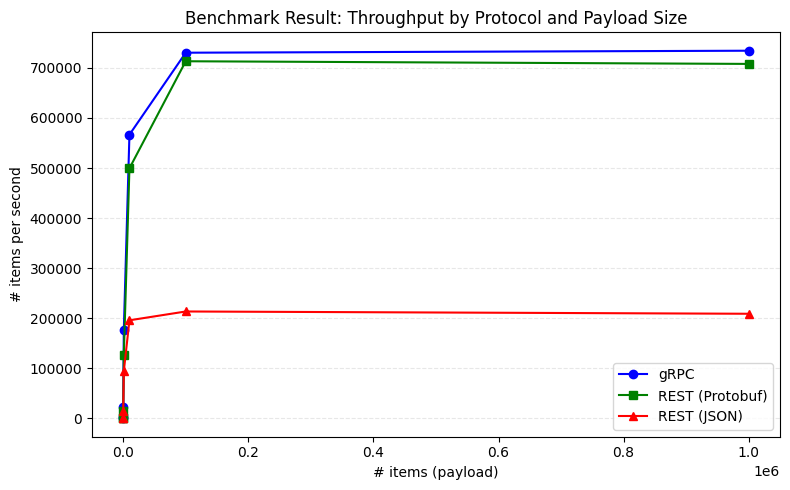

In [58]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_items_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

# plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('# items per second')
plt.title('Benchmark Result: Throughput by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


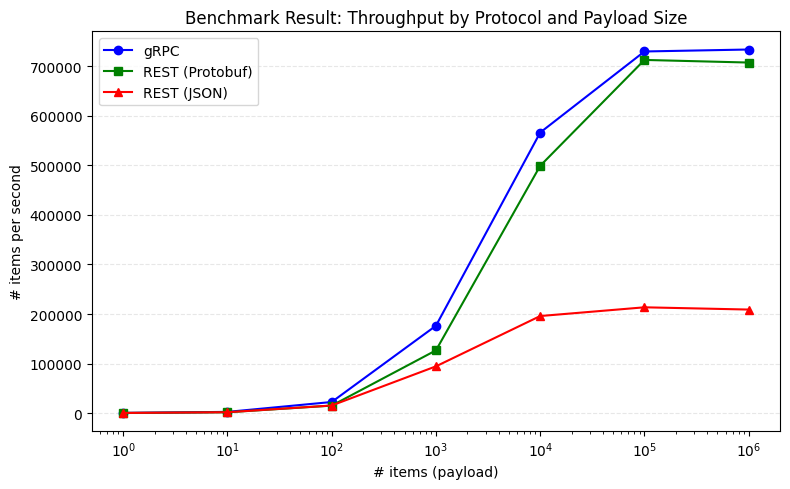

In [59]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_items_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('# items per second')
plt.title('Benchmark Result: Throughput by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


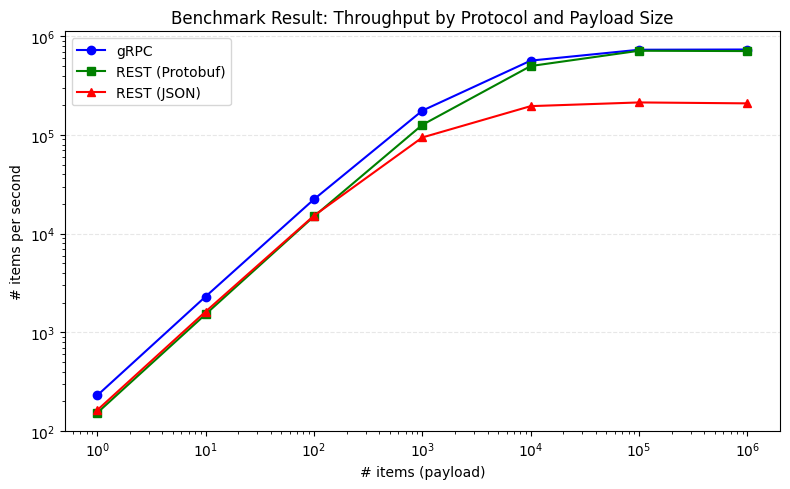

In [60]:
import matplotlib.pyplot as plt
pivot = summary_df.pivot(index='size', columns='protocol', values='mean_items_per_s_total_runtime').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.yscale('log')
plt.ylabel('# items per second')
plt.title('Benchmark Result: Throughput by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

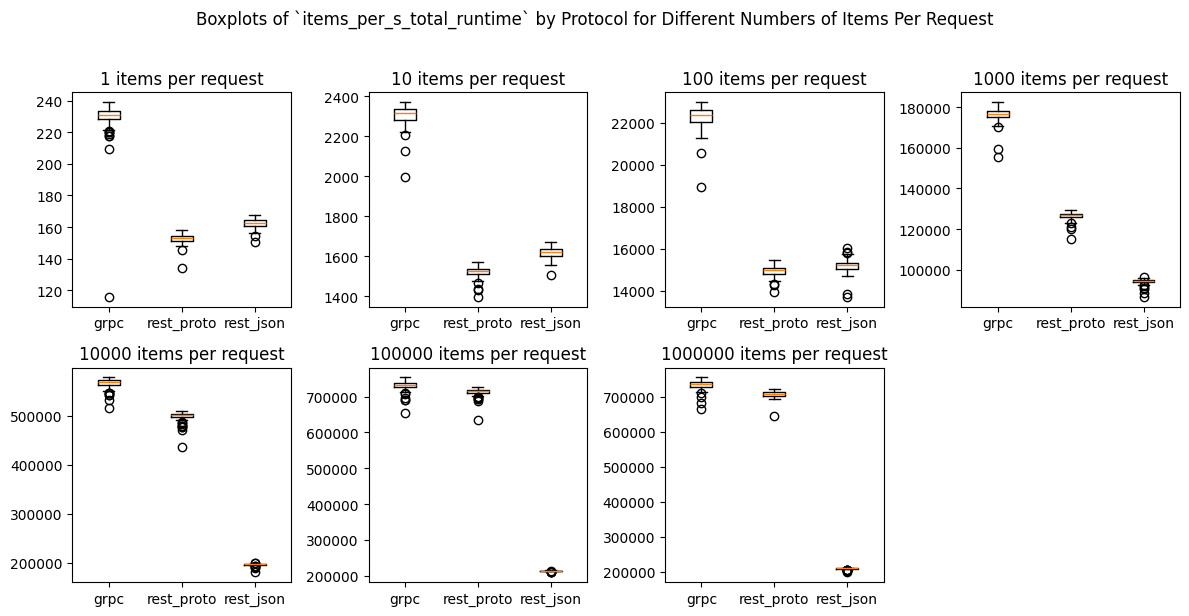

In [61]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='items_per_s_total_runtime')

#### Mixed Model

In [62]:
from statsmodels.regression.mixed_linear_model import MixedLM

In [63]:
# 1) create a single grouping column that uniquely identifies each protocol×size cell
df_latency['batch'] = df_latency['protocol'].astype(str) + "_" + df_latency['size'].astype(str)

# 2) log‐transform throughput
df_latency['log_throughput'] = np.log10(df_latency['items_per_s_total_runtime'])

# 3) fit a random‐intercept model, with one intercept per cell
md = MixedLM.from_formula(
    "log_throughput ~ C(protocol)*C(size)",
    groups="batch",
    data=df_latency
)
mres = md.fit()
print(mres.summary())

                          Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          log_throughput
No. Observations:            2100             Method:                      REML          
No. Groups:                  21               Scale:                       0.0001        
Min. group size:             100              Log-Likelihood:              6559.4547     
Max. group size:             100              Converged:                   Yes           
Mean group size:             100.0                                                       
-----------------------------------------------------------------------------------------
                                             Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                     2.359     0.010 232.887 0.000  2.339  2.379
C(protocol)[T.rest_json]            

/Users/haochen/projects/benchmark_grpc_proto_rest_json/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Plot

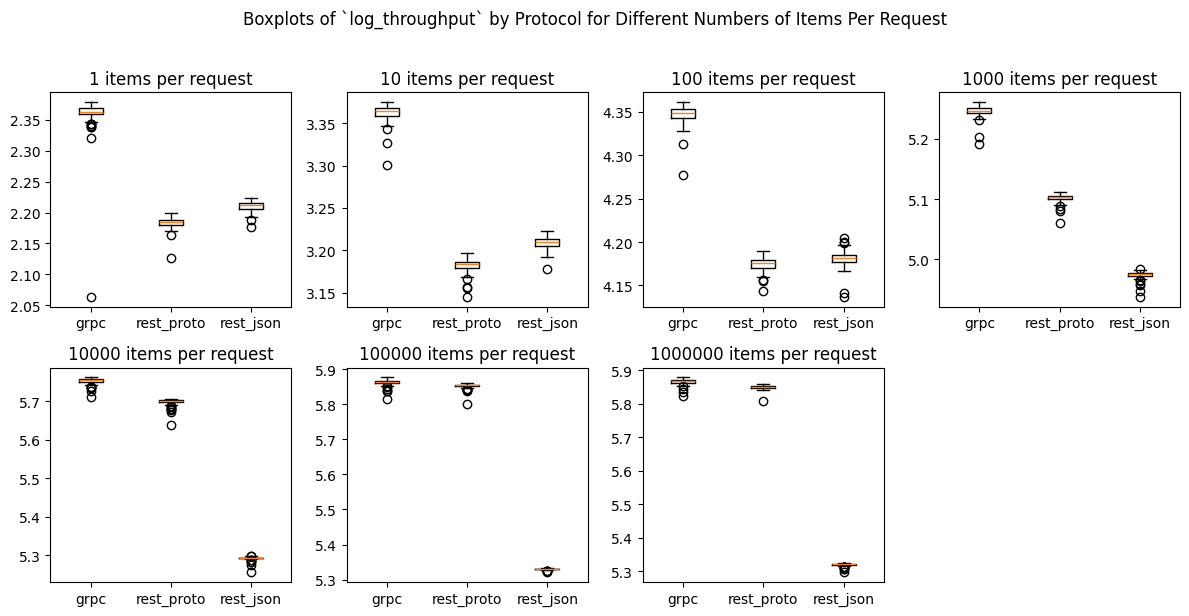

In [64]:
boxplots_by_size(df_latency, protocols=['grpc', 'rest_proto', 'rest_json'], col='log_throughput')

#### Compare protocols within each batch

##### Function Definition

In [65]:
from statsmodels.stats.multitest import multipletests

In [66]:
def mixed_model_t_test(size, model_results=mres):
    res = {}
    pvals_keys = []
    pvals = []
    names = model_results.model.exog_names

    # Compare gRPC vs REST-Proto
    r = np.zeros((1, len(names)))
    r[0, names.index(f'C(protocol)[T.rest_proto]')] = 1.0
    r[0, names.index(f'C(protocol)[T.rest_proto]:C(size)[T.{size}]')] = 1.0

    t1 = model_results.t_test(r)
    print(f"=== gRPC vs REST-Proto at size={size} ===")
    print(t1.summary())

    res['grpc_vs_rest_proto'] = t1
    pvals_keys.append('grpc_vs_rest_proto')
    pvals.append(t1.pvalue)

    # Compare gRPC vs REST-Json
    r = np.zeros((1, len(names)))
    r[0, names.index(f'C(protocol)[T.rest_json]')] = 1.0
    r[0, names.index(f'C(protocol)[T.rest_json]:C(size)[T.{size}]')] = 1.0

    t2 = model_results.t_test(r)
    print(f"=== gRPC vs REST-Json at size={size} ===")
    print(t2.summary())

    res['grpc_vs_rest_json'] = t2
    pvals_keys.append('grpc_vs_rest_json')
    pvals.append(t2.pvalue)
   

    # Compare REST_proto vs REST-Json
    r = np.zeros((1, len(names)))
    r[0, names.index('C(protocol)[T.rest_proto]')] = -1.0
    r[0, names.index('C(protocol)[T.rest_json]')] =  1.0
    r[0, names.index(f'C(protocol)[T.rest_proto]:C(size)[T.{size}]')] = -1.0
    r[0, names.index(f'C(protocol)[T.rest_json]:C(size)[T.{size}]')] =  1.0

    t3 = model_results.t_test(r)
    print(f"=== REST-JSON vs REST-Proto at size={size} ===")
    print(t3.summary())

    res['rest_proto_vs_rest_json'] = t3
    pvals_keys.append('rest_proto_vs_rest_json')
    pvals.append(t3.pvalue)

    reject, pvals_adj, _, _ = multipletests(
        pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
    )

    for i in range(len(pvals_adj)):
        print(f'Adjusted p_value of {pvals_keys[i]}: {pvals_adj[i]}; rejected: {reject[i]}')
    
    return res

In [67]:
def mixed_model_t_test_at_size_1(model_results=mres):
    model_results=mres
    names = model_results.model.exog_names

    t_res_1 = {}
    pvals_keys = []
    pvals = []

    # Compare gRPC vs rest_proto
    r = np.zeros((1, len(names)))

    r[0, names.index('C(protocol)[T.rest_proto]')] = 1.0

    t_res_1['grpc_vs_rest_proto'] = mres.t_test(r)
    print("=== gRPC vs REST-Proto @ size=1 ===")
    print(t_res_1['grpc_vs_rest_proto'].summary())
    pvals_keys.append('grpc_vs_rest_proto')
    pvals.append(t_res_1['grpc_vs_rest_proto'].pvalue)

    # Compare gRPC vs rest_json
    r = np.zeros((1, len(names)))

    r[0, names.index('C(protocol)[T.rest_json]')] = 1.0

    t_res_1['grpc_vs_rest_json'] = mres.t_test(r)
    print("=== gRPC vs REST-json @ size=1 ===")
    print(t_res_1['grpc_vs_rest_json'].summary())
    pvals_keys.append('grpc_vs_rest_json')
    pvals.append(t_res_1['grpc_vs_rest_json'].pvalue)

    # Compare REST_proto vs REST-Json at size 1
    r = np.zeros((1, len(names)))
    r[0, names.index('C(protocol)[T.rest_proto]')] = -1.0
    r[0, names.index('C(protocol)[T.rest_json]')] =  1.0

    t_res_1['rest_proto_vs_rest_json'] = model_results.t_test(r)
    print(f"=== REST-JSON vs REST-Proto at size={1} ===")
    print(t_res_1['rest_proto_vs_rest_json'].summary())
    pvals_keys.append('rest_proto_vs_rest_json')
    pvals.append(t_res_1['rest_proto_vs_rest_json'].pvalue)

    reject, pvals_adj, _, _ = multipletests(
            pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
        )

    for i in range(len(pvals_adj)):
        print(f'{pvals_keys[i]}, adjusted p_value: {pvals_adj[i]}')

    return t_res_1

##### Run test

In [68]:
t_res_1 = mixed_model_t_test_at_size_1()

=== gRPC vs REST-Proto @ size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1761      0.014    -12.294      0.000      -0.204      -0.148
=== gRPC vs REST-json @ size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1485      0.014    -10.365      0.000      -0.177      -0.120
=== REST-JSON vs REST-Proto at size=1 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0

In [69]:
t_res_10 = mixed_model_t_test(10)

=== gRPC vs REST-Proto at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1794      0.014    -12.524      0.000      -0.207      -0.151
=== gRPC vs REST-Json at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1524      0.014    -10.639      0.000      -0.180      -0.124
=== REST-JSON vs REST-Proto at size=10 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0           

In [70]:
t_res_100 = mixed_model_t_test(100)

=== gRPC vs REST-Proto at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1730      0.014    -12.079      0.000      -0.201      -0.145
=== gRPC vs REST-Json at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1660      0.014    -11.589      0.000      -0.194      -0.138
=== REST-JSON vs REST-Proto at size=100 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0        

In [71]:
t_res_1000 = mixed_model_t_test(1_000)

=== gRPC vs REST-Proto at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1439      0.014    -10.044      0.000      -0.172      -0.116
=== gRPC vs REST-Json at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.2717      0.014    -18.969      0.000      -0.300      -0.244
=== REST-JSON vs REST-Proto at size=1000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0     

In [72]:
t_res_10000 = mixed_model_t_test(10_000)

=== gRPC vs REST-Proto at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0548      0.014     -3.827      0.000      -0.083      -0.027
=== gRPC vs REST-Json at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.4611      0.014    -32.191      0.000      -0.489      -0.433
=== REST-JSON vs REST-Proto at size=10000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0  

In [73]:
t_res_100000 = mixed_model_t_test(100_000)

=== gRPC vs REST-Proto at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0103      0.014     -0.716      0.474      -0.038       0.018
=== gRPC vs REST-Json at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.5339      0.014    -37.273      0.000      -0.562      -0.506
=== REST-JSON vs REST-Proto at size=100000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [74]:
t_res_1000000 = mixed_model_t_test(1_000_000)

=== gRPC vs REST-Proto at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0158      0.014     -1.106      0.269      -0.044       0.012
=== gRPC vs REST-Json at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.5457      0.014    -38.092      0.000      -0.574      -0.518
=== REST-JSON vs REST-Proto at size=1000000 ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

#### Compare protocols overall

###### Define functions

In [75]:
def mixed_model_t_test_overall(mres=mres):
    names = mres.model.exog_names
    size_levels = [1, 10, 100, 1000, 10000, 100000, 1000000]
    K = len(size_levels)

    r = np.zeros((1, len(names)))

    for size in size_levels:
        if size == 1:
            term = 'C(protocol)[T.rest_proto]'
            r[0, names.index(term)] = 1.0
        else:
            term = f'C(protocol)[T.rest_proto]:C(size)[T.{size}]'
            r[0, names.index(term)] = 1.0 / K

    t_grpc_vs_rest_proto = mres.t_test(r)
    print(f"=== gRPC vs REST-Proto overall ===")
    print(t_grpc_vs_rest_proto.summary())

    # Compare gRPC vs REST-Proto
    r = np.zeros((1, len(names)))

    for size in size_levels:
        if size == 1:
            term = 'C(protocol)[T.rest_json]'
            r[0, names.index(term)] = 1.0
        else:
            term = f'C(protocol)[T.rest_json]:C(size)[T.{size}]'
            r[0, names.index(term)] = 1.0 / K

    t_grpc_vs_rest_json = mres.t_test(r)
    print(f"=== gRPC vs REST-JSON overall ===")
    print(t_grpc_vs_rest_json.summary())

    # 1×k_fe contrast for REST-Proto minus REST-JSON, averaged across sizes
    r = np.zeros((1, len(names)))

    # 1) main‐effect difference at size=1
    r[0, names.index('C(protocol)[T.rest_proto]')] =  -1.0
    r[0, names.index('C(protocol)[T.rest_json]')]  = 1.0

    # 2) add each interaction difference, weighted by 1/K
    for s in size_levels:
        if s == size_levels[0]:
            continue
        proto_term = f'C(protocol)[T.rest_proto]:C(size)[T.{s}]'
        json_term  = f'C(protocol)[T.rest_json]:C(size)[T.{s}]'
        r[0, names.index(proto_term)] =  -1.0 / K
        r[0, names.index(json_term)]  = 1.0 / K

    # 3) run the test
    t_rest_proto_vs_rest_json = mres.t_test(r)
    print("=== REST-Proto vs REST-JSON (averaged across payload sizes) ===")
    print(t_rest_proto_vs_rest_json.summary())

    res = {
        'grpc_vs_rest_proto': t_grpc_vs_rest_proto,
        'grpc_vs_rest_json': t_grpc_vs_rest_json,
        'rest_proto_vs_rest_json': t_grpc_vs_rest_json,
    }

    p_values = [v.pvalue for v in res.values()]
    p_value_keys = [k for k in res.keys()]

    reject, pvals_adj, _, _ = multipletests(
        p_values, alpha=0.05, method='hs', is_sorted=False, returnsorted=False
    )

    for i in range(len(pvals_adj)):
        print(f'{p_value_keys[i]}, adjusted p_value: {pvals_adj[i]}')

    return res


In [76]:
t_res_res = mixed_model_t_test_overall()

=== gRPC vs REST-Proto overall ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1076      0.005    -19.877      0.000      -0.118      -0.097
=== gRPC vs REST-JSON overall ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.3256      0.005    -60.141      0.000      -0.336      -0.315
=== REST-Proto vs REST-JSON (averaged across payload sizes) ===
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

## time percentage

In [77]:
summary_df

,protocol,size,count,mean_total_runtime_ns,mean_items_per_s_total_runtime,mean_kb_per_s_total_runtime,mean_request_latency_ns,mean_server_processing_ns,mean_response_latency_ns
0,grpc,1,100,4.389382e+06,229.040333,22.367220,3896819.55,1.327188e+05,3.598433e+05
1,grpc,10,100,4.348493e+06,2300.854059,224.692779,3842957.48,1.470088e+05,3.585271e+05
2,grpc,100,100,4.494099e+06,22264.689750,2174.286108,3862522.06,2.449942e+05,3.865829e+05
3,grpc,1000,100,5.674806e+06,176300.185443,17216.814985,3863455.43,1.176638e+06,6.347129e+05
4,grpc,10000,100,1.765625e+07,566555.574082,55327.692781,3821264.95,1.079093e+07,3.044049e+06
5,grpc,100000,100,1.369868e+08,730255.105042,71313.975102,3830353.74,1.062646e+08,2.689180e+07
6,grpc,1000000,100,1.362419e+09,734230.731234,71702.219847,3879167.95,1.098976e+09,2.595646e+08
7,rest_json,1,100,6.159595e+06,162.396082,40.916200,5665212.03,2.996433e+05,1.947396e+05
8,rest_json,10,100,6.175705e+06,1619.694358,389.580782,5637512.51,3.167808e+05,2.214117e+05
9,rest_json,100,100,6.585960e+06,15190.689431,3636.419629,5631114.99,5.330342e+05,4.218103e+05


In [78]:
sizes = [1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]
summary_df['req_bar_width'] = np.repeat(-0.1, len(summary_df))
summary_df['server_bar_width'] = np.repeat(-0.1, len(summary_df))
summary_df['res_bar_width'] = np.repeat(-0.1, len(summary_df))

for size in sizes:
    i_row = summary_df['size']==size
    max_run_time = summary_df.loc[i_row,  'mean_total_runtime_ns'].max()
    summary_df.loc[i_row, 'req_bar_width'] = summary_df.loc[summary_df['size']==size, 'mean_request_latency_ns'] / max_run_time
    summary_df.loc[i_row, 'server_bar_width'] = summary_df.loc[summary_df['size']==size, 'mean_server_processing_ns'] / max_run_time
    summary_df.loc[i_row, 'res_bar_width'] = summary_df.loc[summary_df['size']==size, 'mean_response_latency_ns'] / max_run_time
summary_df

,protocol,size,count,mean_total_runtime_ns,mean_items_per_s_total_runtime,mean_kb_per_s_total_runtime,mean_request_latency_ns,mean_server_processing_ns,mean_response_latency_ns,req_bar_width,server_bar_width,res_bar_width
0,grpc,1,100,4.389382e+06,229.040333,22.367220,3896819.55,1.327188e+05,3.598433e+05,0.593605,0.020217,0.054815
1,grpc,10,100,4.348493e+06,2300.854059,224.692779,3842957.48,1.470088e+05,3.585271e+05,0.584753,0.022369,0.054554
2,grpc,100,100,4.494099e+06,22264.689750,2174.286108,3862522.06,2.449942e+05,3.865829e+05,0.577120,0.036606,0.057761
3,grpc,1000,100,5.674806e+06,176300.185443,17216.814985,3863455.43,1.176638e+06,6.347129e+05,0.364210,0.110922,0.059835
4,grpc,10000,100,1.765625e+07,566555.574082,55327.692781,3821264.95,1.079093e+07,3.044049e+06,0.074854,0.211382,0.059629
5,grpc,100000,100,1.369868e+08,730255.105042,71313.975102,3830353.74,1.062646e+08,2.689180e+07,0.008179,0.226906,0.057422
6,grpc,1000000,100,1.362419e+09,734230.731234,71702.219847,3879167.95,1.098976e+09,2.595646e+08,0.000811,0.229649,0.054240
7,rest_json,1,100,6.159595e+06,162.396082,40.916200,5665212.03,2.996433e+05,1.947396e+05,0.862985,0.045645,0.029665
8,rest_json,10,100,6.175705e+06,1619.694358,389.580782,5637512.51,3.167808e+05,2.214117e+05,0.857817,0.048202,0.033691
9,rest_json,100,100,6.585960e+06,15190.689431,3636.419629,5631114.99,5.330342e+05,4.218103e+05,0.841374,0.079643,0.063025


In [79]:
import matplotlib.ticker as mtick

def stacked_bars_by_size(
    df=summary_df,
    perc_cols=('req_bar_width',
               'server_bar_width',
               'res_bar_width'),
    protocols=('grpc','rest_proto','rest_json'),
    n_col_plot=4,
    figsize=(14, 6)
):
    """
    For each unique size in df (sorted), draw a subplot with a stacked
    horizontal bar per protocol showing the three perc_cols.
    """
    # 1) collect and sort sizes
    sizes = sorted(df['size'].unique())
    n = len(sizes)
    n_rows = n // n_col_plot + 1

    # 2) prepare the figure + axes
    fig, axes = plt.subplots(
        n_rows, n_col_plot, 
        figsize=figsize, 
        sharex=True, sharey=False
    )
    axes = np.array(axes).flatten()

    # 3) for each size → one subplot
    for ax, size in zip(axes, sizes):
        sub = df[df['size']==size].set_index('protocol')
        # ensure protocols in right order
        sub = sub.reindex(protocols)

        # y positions: one per protocol
        y = np.arange(len(protocols))

        # bottom = 0 initially
        left = np.zeros_like(y, dtype=float)

        colors = ['gold','forestgreen','skyblue']  # or pick your own
        labels = ['Request', 'Server', 'Response']

        # stack each phase
        for col, c, label in zip(perc_cols, colors, labels):
            vals = sub[col].values
            ax.barh(y, vals, left=left, color=c, label=label)
            left += vals

        # format
        ax.set_title(f"{size} items")
        ax.set_yticks(y)
        ax.set_yticklabels(protocols)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.invert_yaxis()  # largest on top (optional)

    # 4) hide unused axes
    for ax in axes[n:]:
        ax.axis('off')

    # 5) common legend and title
    fig.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Runtime Breakdown by Phase", y=1.02)
    plt.tight_layout()
    plt.show()

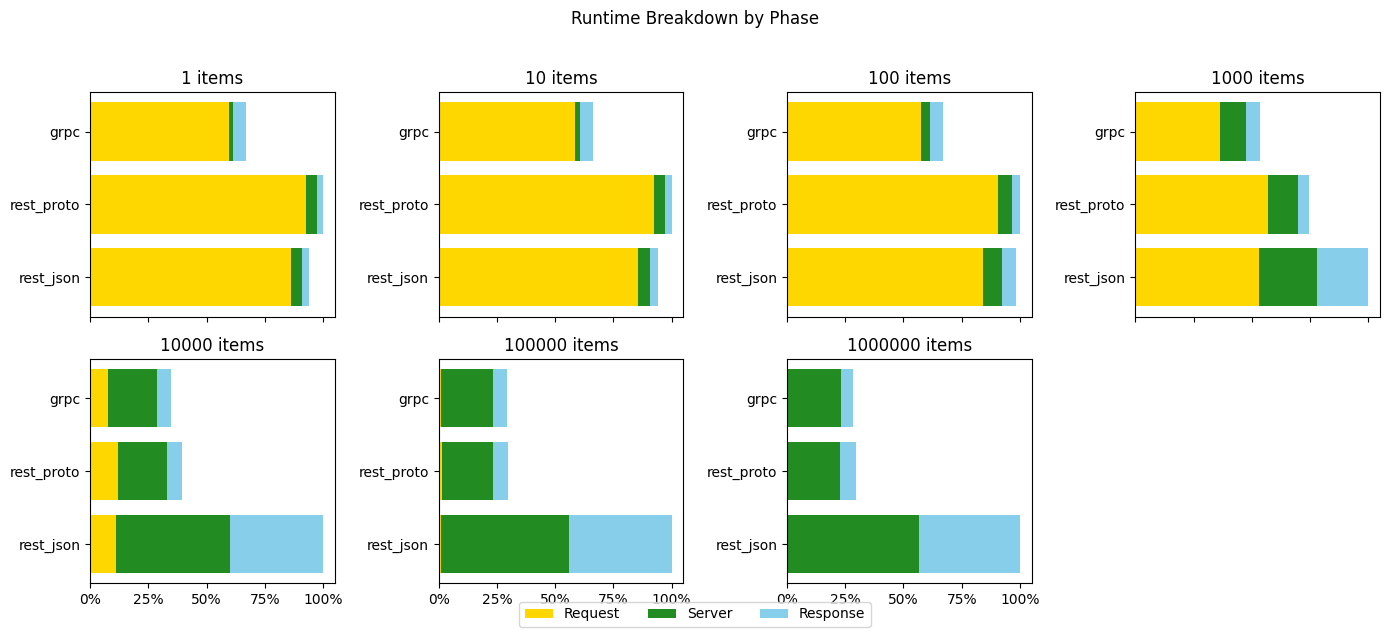

In [80]:
stacked_bars_by_size()

In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def stacked_bars_by_size(
    df=summary_df,
    perc_cols=('req_bar_width','server_bar_width','res_bar_width'),
    protocols=('grpc','rest_proto','rest_json'),
    n_col_plot=4,
    figsize=(14, 6)
):
    sizes = sorted(df['size'].unique())
    n     = len(sizes)
    n_rows=math.ceil(n/ n_col_plot)

    fig, axes = plt.subplots(
        n_rows, n_col_plot,
        figsize=figsize,
        sharex=True, sharey=False
    )
    axes = np.array(axes).flatten()

    colors = ['gold','forestgreen','skyblue']
    labels = ['Request', 'Server', 'Response']

    for ax, size in zip(axes, sizes):
        sub = df[df['size']==size].set_index('protocol').reindex(protocols)
        y   = np.arange(len(protocols))
        left= np.zeros_like(y, float)

        for col, c in zip(perc_cols, colors):
            vals = sub[col].values
            ax.barh(y, vals, left=left, color=c)
            left += vals

        ax.set_title(f"{size:,} items per request")
        ax.set_yticks(y)
        ax.set_yticklabels(protocols)
        ax.invert_yaxis()

        # **remove x-axis ticks & labels**
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # hide extra axes
    for ax in axes[n:]:
        ax.axis('off')

    # common legend & title
    fig.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("Runtime Breakdown by Phase", y=0.98)
    plt.tight_layout()
    plt.show()


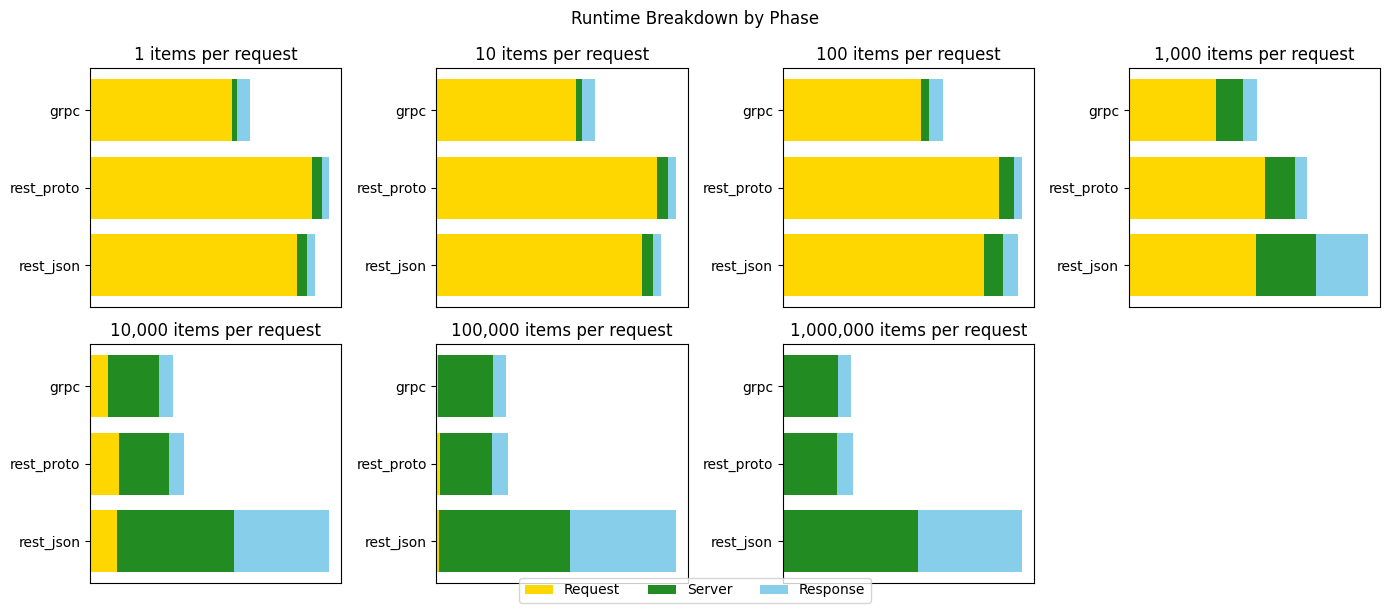

In [82]:
stacked_bars_by_size()

## Server usage

In [83]:
df_server_usage.head()

,protocol,size,usage_side,ts,rss,cpu,perf_base_ns,epoch_base_ns
0,grpc,1,server,67553458,16015360,0.5,37801799555250,1747488516924895000
1,grpc,1,server,69210583,16154624,0.2,37801799555250,1747488516924895000
2,grpc,1,server,70512000,16261120,0.2,37801799555250,1747488516924895000
3,grpc,1,server,71805083,16384000,0.2,37801799555250,1747488516924895000
4,grpc,1,server,73092791,16515072,0.3,37801799555250,1747488516924895000


In [84]:
# Compute Δt _within_ each (protocol,size)
df_server_usage["dt_ns"] = df_server_usage.groupby(
    ["protocol", "size"]
)["ts"].diff().fillna(0)

# Compute CPU-time per interval
df_server_usage["cpu_ns"] = df_server_usage["dt_ns"] * (df_server_usage["cpu"] / 100.0)

# Aggregate per scenario
def summarize(g):
    return pd.Series({
        # how much RSS grew
        "mem_overhead_bytes": g["rss"].max() - g["rss"].min(),
        # total real time elapsed
        "wallclock_ns":      g["ts"].max() - g["ts"].min(),
        # total CPU-time spent (ns → ms)
        "total_cpu_ns":      g["cpu_ns"].sum()
    })

report = df_server_usage.groupby(["protocol", "size"]).apply(summarize).reset_index()

# 5) Compute avg CPU%
report["avg_cpu_percent"] = (
    (report["total_cpu_ns"])  # back to ns
    / report["wallclock_ns"]
) * 100

report['total_cpu_ms'] = report['total_cpu_ns'] / 1_000_000
print(report)

      protocol     size  mem_overhead_bytes  wallclock_ns  total_cpu_ns  \
0         grpc        1        1.911194e+07  1.370984e+10  3.984439e+06   
1         grpc       10        1.511014e+07  1.366956e+10  3.630537e+06   
2         grpc      100        1.569178e+07  1.372326e+10  3.939601e+06   
3         grpc     1000        1.759642e+07  1.387016e+10  6.196539e+06   
4         grpc    10000        4.462182e+07  1.508264e+10  2.928043e+07   
5         grpc   100000        2.771722e+08  2.900627e+10  2.539179e+08   
6         grpc  1000000        1.564680e+09  1.702365e+11  2.610625e+09   
7    rest_json        1        3.012608e+07  1.544945e+10  9.007372e+06   
8    rest_json       10        2.935603e+07  1.529210e+10  8.561726e+06   
9    rest_json      100        2.943386e+07  1.529867e+10  9.160013e+06   
10   rest_json     1000        3.279667e+07  1.581150e+10  1.434919e+07   
11   rest_json    10000        8.685568e+07  1.991382e+10  6.902412e+07   
12   rest_json   100000  

/var/folders/7n/c_p139yj6jq0tctqpx0x_2rr0000gn/T/ipykernel_14035/3898766748.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report = df_server_usage.groupby(["protocol", "size"]).apply(summarize).reset_index()


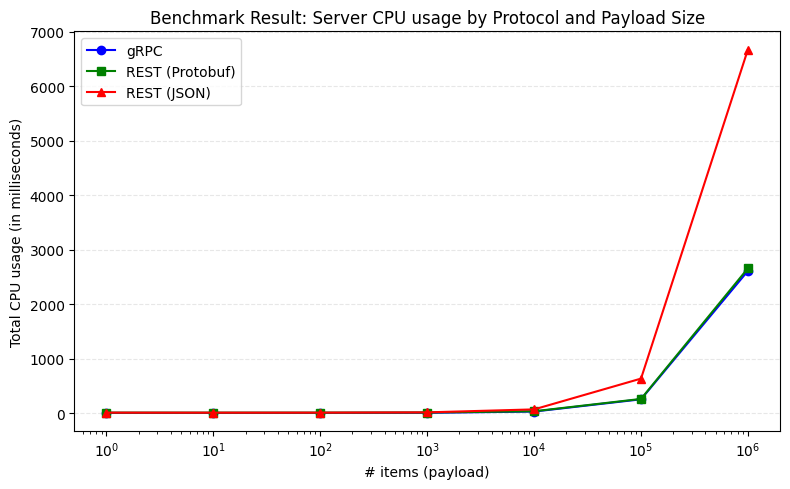

In [85]:
pivot = report.pivot(index='size', columns='protocol', values='total_cpu_ms').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('Total CPU usage (in milliseconds)')
# plt.yscale('log')
plt.title('Benchmark Result: Server CPU usage by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

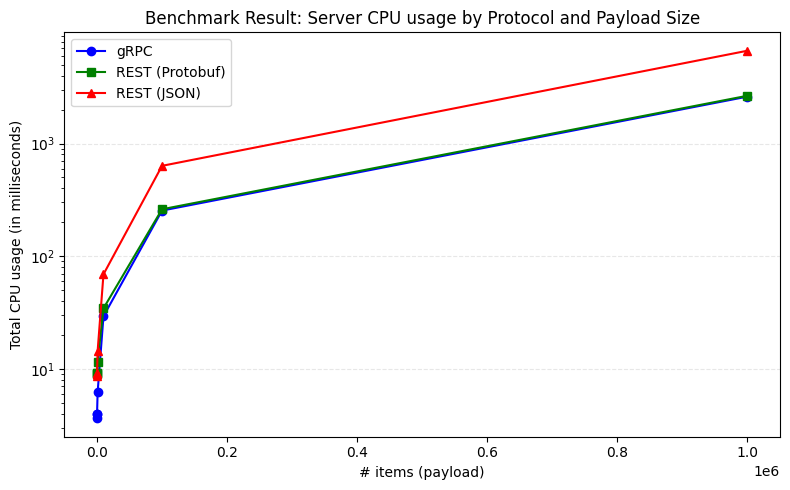

In [86]:
pivot = report.pivot(index='size', columns='protocol', values='total_cpu_ms').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

# plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('Total CPU usage (in milliseconds)')
plt.yscale('log')
plt.title('Benchmark Result: Server CPU usage by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

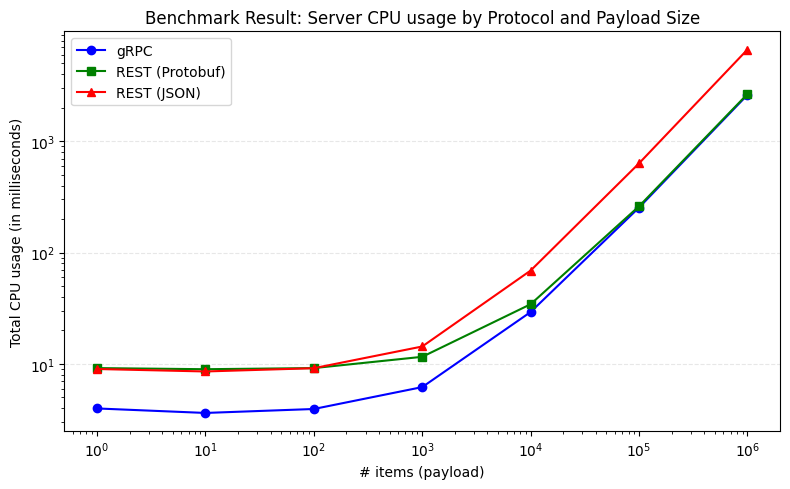

In [87]:
pivot = report.pivot(index='size', columns='protocol', values='total_cpu_ms').sort_index()

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['grpc'], marker='o', label='gRPC', color='blue')
plt.plot(pivot.index, pivot['rest_proto'], marker='s', label='REST (Protobuf)', color='green')
plt.plot(pivot.index, pivot['rest_json'],  marker='^', label='REST (JSON)',  color='red')

plt.xscale('log')
plt.xlabel('# items (payload)')
plt.ylabel('Total CPU usage (in milliseconds)')
plt.yscale('log')
plt.title('Benchmark Result: Server CPU usage by Protocol and Payload Size')
plt.legend()
plt.grid(True, axis='y', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

### ANOVA

In [88]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import itertools
from scipy.stats import ttest_ind

In [89]:
df_latency['log_throughput'] = np.log10(df_latency['items_per_s_total_runtime'])

# 2) fit two-way ANOVA with interaction
model = ols('log_throughput ~ C(protocol) * C(size)', data=df_latency).fit()

# 3) get ANOVA table (Type II SS; for balanced designs these equal Type I):
anova2 = anova_lm(model, typ=2)

print(anova2)

                          sum_sq      df             F  PR(>F)
C(protocol)            38.532036     2.0  1.896506e+05     0.0
C(size)              3300.517068     6.0  5.414930e+06     0.0
C(protocol):C(size)    21.378432    12.0  1.753706e+04     0.0
Residual                0.211199  2079.0           NaN     NaN


#### T test

Manual t test

In [90]:
results = []

for size_level in df_latency['size'].unique():
    sub = df_latency[df_latency['size'] == size_level]
    prots = sub['protocol'].unique()
    
    # all 3 choose 2 = 3 comparisons per size
    for p1, p2 in itertools.combinations(prots, 2):
        x = sub.loc[sub['protocol'] == p1, 'log_throughput']
        y = sub.loc[sub['protocol'] == p2, 'log_throughput']
        # Welch’s t-test (doesn't assume equal variances)
        t_stat, p_val = ttest_ind(x, y, equal_var=False)
        results.append({
            'size': size_level,
            'contrast': f"{p1} vs {p2}",
            't':     t_stat,
            'p_raw': p_val
        })

# adjust all p-values (here Bonferroni; you can choose method='holm' or 'fdr_bh'…)
p_raw = [r['p_raw'] for r in results]
reject, p_adj, _, _ = multipletests(p_raw, alpha=0.05, method='bonferroni')

for i, r in enumerate(results):
    r['p_adj']    = p_adj[i]
    r['reject']   = reject[i]

# turn into a DataFrame for easy viewing
res_df = pd.DataFrame(results)
print(res_df)

       size                 contrast           t          p_raw  \
0         1        grpc vs rest_json   46.069123   7.466301e-74   
1         1       grpc vs rest_proto   54.266483   7.534836e-83   
2         1  rest_json vs rest_proto   24.565526   1.166849e-61   
3        10        grpc vs rest_json  123.462664  2.729229e-176   
4        10       grpc vs rest_proto  143.542145  1.411170e-190   
5        10  rest_json vs rest_proto   25.889971   1.943283e-65   
6       100        grpc vs rest_json  117.431540  2.053694e-182   
7       100       grpc vs rest_proto  135.303308  1.568046e-176   
8       100  rest_json vs rest_proto    6.024388   8.985390e-09   
9      1000        grpc vs rest_json  237.913619  8.615775e-221   
10     1000       grpc vs rest_proto  124.289845  4.860503e-175   
11     1000  rest_json vs rest_proto -138.075156  1.598991e-198   
12    10000        grpc vs rest_json  499.546737  9.968323e-264   
13    10000       grpc vs rest_proto   47.064143  6.362297e-10

Use Tukey’s HSD

In [91]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_latency['log_throughput'] = np.log10(df_latency['items_per_s_total_runtime'])

for size_level in df_latency['size'].unique():
    sub = df_latency[df_latency['size'] == size_level]
    print(f"\n### size = {size_level}")
    tukey = pairwise_tukeyhsd(
        endog=sub['log_throughput'],
        groups=sub['protocol'],
        alpha=0.05
    )
    print(tukey.summary())


### size = 1
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj  lower   upper  reject
----------------------------------------------------------
     grpc  rest_json  -0.1485   0.0 -0.1549 -0.1421   True
     grpc rest_proto  -0.1761   0.0 -0.1825 -0.1697   True
rest_json rest_proto  -0.0276   0.0  -0.034 -0.0212   True
----------------------------------------------------------

### size = 10
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj  lower   upper  reject
----------------------------------------------------------
     grpc  rest_json  -0.1524   0.0 -0.1552 -0.1496   True
     grpc rest_proto  -0.1794   0.0 -0.1822 -0.1766   True
rest_json rest_proto   -0.027   0.0 -0.0298 -0.0242   True
----------------------------------------------------------

### size = 100
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj  lower  upper  reject
-------------